In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
import pickle
import math
from scipy import interpolate
import pycwt as wavelet
from pycwt.helpers import find


# シミュレーションモデルの定義

In [2]:
class AFM_Simulator():
    def __init__(self, model, tip_r=2, tap_dist=2):
        self.model = model
        self.tip_r = tip_r
        self.tap_dist = tap_dist
        '''
        断面モデルの頂点の座標を入力する
        1βの格子座標で(x座標のndarray, y座標のndarray)を自分で入力し、lattice2orthogonalで直交系に変換している
        '''
        self.formation_dict = {
            '18chain_nishiyama': self.lattice2orthogonal(np.array([-0.25, 0.25, 1.5, 1.5, -0.25, -0.75, -2, -2]),
                                                         np.array([-0.25, -0.25, 1, 2, 3.75, 3.75, 2.5, 1.5])),
            '18chain_daicho': self.lattice2orthogonal(np.array([-0.25, 1.25, 2.5, 0.75, -0.75, -2]),
                                                      np.array([-0.25, -0.25, 1, 2.75, 2.75, 1.5]))
            }

    @staticmethod
    def lattice2orthogonal(lattice_x, lattice_y):
        '''
        単位はnm
        入力：セルロ―スⅠβ結晶格子を基底とした座標のndarray
        後に回転するとき用に重心を原点に変換
        出力：直交座標のndarray（小数第3位まで）
        '''
        a = 0.8201
        b = 0.7784
        gamma = math.radians(96.5)

        gx = np.mean(lattice_x)
        gy = np.mean(lattice_y)
        x = np.round(a * (lattice_x - gx) + round(math.cos(gamma), 5) * b * (lattice_y - gy), 4)
        y = np.round(round(math.sin(gamma), 5) * b * (lattice_y - gy), 4)
        return x, y

    @staticmethod
    def rotation(x, t, deg=True):
        #ラジアンでも弧度法でも良い(default: 弧度法)
        if deg == True:
            t = np.deg2rad(t)
        a = np.array([[np.cos(t), -np.sin(t)],
                      [np.sin(t), np.cos(t)]])
        if a.ndim > 2 or a.shape[0] != 2:
            a = a.reshape(2, -1)
        ax = np.dot(a, x)
        return ax

    def calc_mid_height_and_range(self, angles):
        max_heights, min_heights = self.calc_max_and_min_heights(angles)
        mid_heights = (max_heights + min_heights) / 2
        height_ranges = max_heights - min_heights
        return mid_heights, height_ranges

    def calc_max_and_min_heights(self, angles):
        '''
        
        Parameters
        ----------
        angles: ndarray
            CNFの回転角度。1D arrayか2D arrayで入力する。
        Returns
        -------
        max_heights: nearray
            与えられた回転角度に対するCNFの最大高さ
        min_heights: ndarray
            与えられた回転角度に対するCNFの最小高さ
        '''
        offsets = np.linspace(0, self.tap_dist, 100)
        if angles.ndim == 1:
            max_heights = []
            min_heights = []
            for angle in angles:
                height_list = []
                for offset in offsets:
                    thin_height = self.calc_thin_height(angle, offset)
                    height_list.append(thin_height)

                max_heights.append(max(height_list))
                min_heights.append(min(height_list))
            return np.array(max_heights), np.array(min_heights)

        if angles.ndim == 2:
            max_heights_mat = []
            min_heights_mat = []
            for angle_row in angles:
                max_heights = []
                min_heights = []
                for angle in angle_row:
                    height_list = []
                    for offset in offsets:
                        thin_height = self.calc_thin_height(angle, offset)
                        height_list.append(thin_height)
                    max_heights.append(max(height_list))
                    min_heights.append(min(height_list))
                max_heights_mat.append(max_heights)
                min_heights_mat.append(min_heights)
            return np.array(max_heights_mat), np.array(min_heights_mat)

    def _simulate_single_scan(self, angle, offset):
        '''
        CNFの回転角と初期のタップ位置を指定した時のシミュレーションを行う。
        半径rの球がCNFに衝突するときの球の中心の軌跡を考える
        球がCNFの
        1. 辺に衝突する場合
           CNFの辺を距離rだけ平行移動させる
        2. 頂点に衝突する場合
           CNFの頂点を中心に半径rの円を考える
        
        Parameters
        ----------
        angle:float or int
            CNFの回転角
        offset: float or int
            初期のタッピング位置
            
        Returns
        -------
        single_scan: List
            タッピング位置に対するCNFの高さ
        '''
        tapping_posi = np.arange(-8 + offset, 8, self.tap_dist)

        coordinate = np.vstack(self.formation_dict[self.model])
        coor_rotated = self.rotation(coordinate, angle)

        cnf_bottom = np.min(coor_rotated[1])
        #0. 辺に衝突する場合の中心が描く直線の軌跡を求める
        edge_vector = np.roll(coor_rotated, shift=-1, axis=1) - coor_rotated
        moves = self.tip_r * self.rotation(edge_vector, -90) / np.linalg.norm(edge_vector, axis=0)  #平行移動の方向

        equations = []  #球の中心が描く直線の方程式
        x_ranges = []  #方程式の定義域
        for i, move in enumerate(moves.T):
            x1, x2 = coor_rotated[0][i] + move[0], np.roll(coor_rotated, shift=-1, axis=1)[0][i] + move[0]
            y1, y2 = coor_rotated[1][i] + move[1], np.roll(coor_rotated, shift=-1, axis=1)[1][i] + move[1]

            x_array = np.array([x1, x2])
            y_array = np.array([y1, y2])
            equation = np.poly1d(np.polyfit(x_array, y_array, 1))
            equations.append(equation)
            x_ranges.append((np.min(x_array), np.max(x_array)))

        #スキャンを1回実行
        single_scan = []
        for x in tapping_posi:
            height_candidate = [0]  #CNFにぶつからなかったら、高さ0

            #1. 辺に衝突する場合
            for equation, x_range in zip(equations, x_ranges):
                if x_range[0] <= x and x <= x_range[1]:
                    height_candidate.append(equation(x) - self.tip_r - cnf_bottom)
            #2. 頂点に衝突する場合
            for vertex in coor_rotated.T:
                if abs(x - vertex[0]) <= self.tip_r:
                    cy = vertex[1] + math.sqrt(self.tip_r ** 2 - (x - vertex[0]) ** 2)
                    height_candidate.append(cy - self.tip_r - cnf_bottom)

            single_scan.append(max(height_candidate))
        return single_scan

    def calc_thin_height(self, angle, offset):
        '''
        simulate_single_scanで得られたシミュレーション結果から、CNFの高さの中央を測定する
        Parameters
        ----------
        angle: float or int
            CNFの回転角
        offset: float or int
            初期のタップ位置

        Returns
        -------
        thin_height: float
            CNFの高さの中央

        '''
        heights_array = np.array(self._simulate_single_scan(angle, offset))
        fiber_heights = heights_array[heights_array > 0]

        if len(fiber_heights) % 2 == 1:
            thin_index = len(fiber_heights) // 2
            thin_height = fiber_heights[thin_index]

        else:
            thin_index = int(len(fiber_heights) / 2)
            thin_height = (fiber_heights[thin_index] + fiber_heights[thin_index - 1]) / 2
        return thin_height

    def visualize(self):
        return self._simulate_single_scan()

    def show_shape(self, angle):
        coordinate = np.vstack(self.formation_dict[self.model])
        coordinate = np.hstack((coordinate, coordinate[:, 0:1]))
        coor_rotated = self.rotation(coordinate, angle)
        return coor_rotated

# シミュレーションの実行

In [3]:
afm_sim = AFM_Simulator('18chain_daicho')
# angles = np.arange(1080)
angles = np.arange(0, 1080, 3.6)
max_heights, min_heights = afm_sim.calc_max_and_min_heights(angles)
mid_heights, height_range = afm_sim.calc_mid_height_and_range(angles)
f_mid = interpolate.interp1d(angles, mid_heights, kind='linear')
f_range = interpolate.interp1d(angles, height_range, kind='linear')

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/2215962684.py:138: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/2215962684.py:138: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/2215962684.py:138: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/2215962684.py:138: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/2215962684.py:138: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/

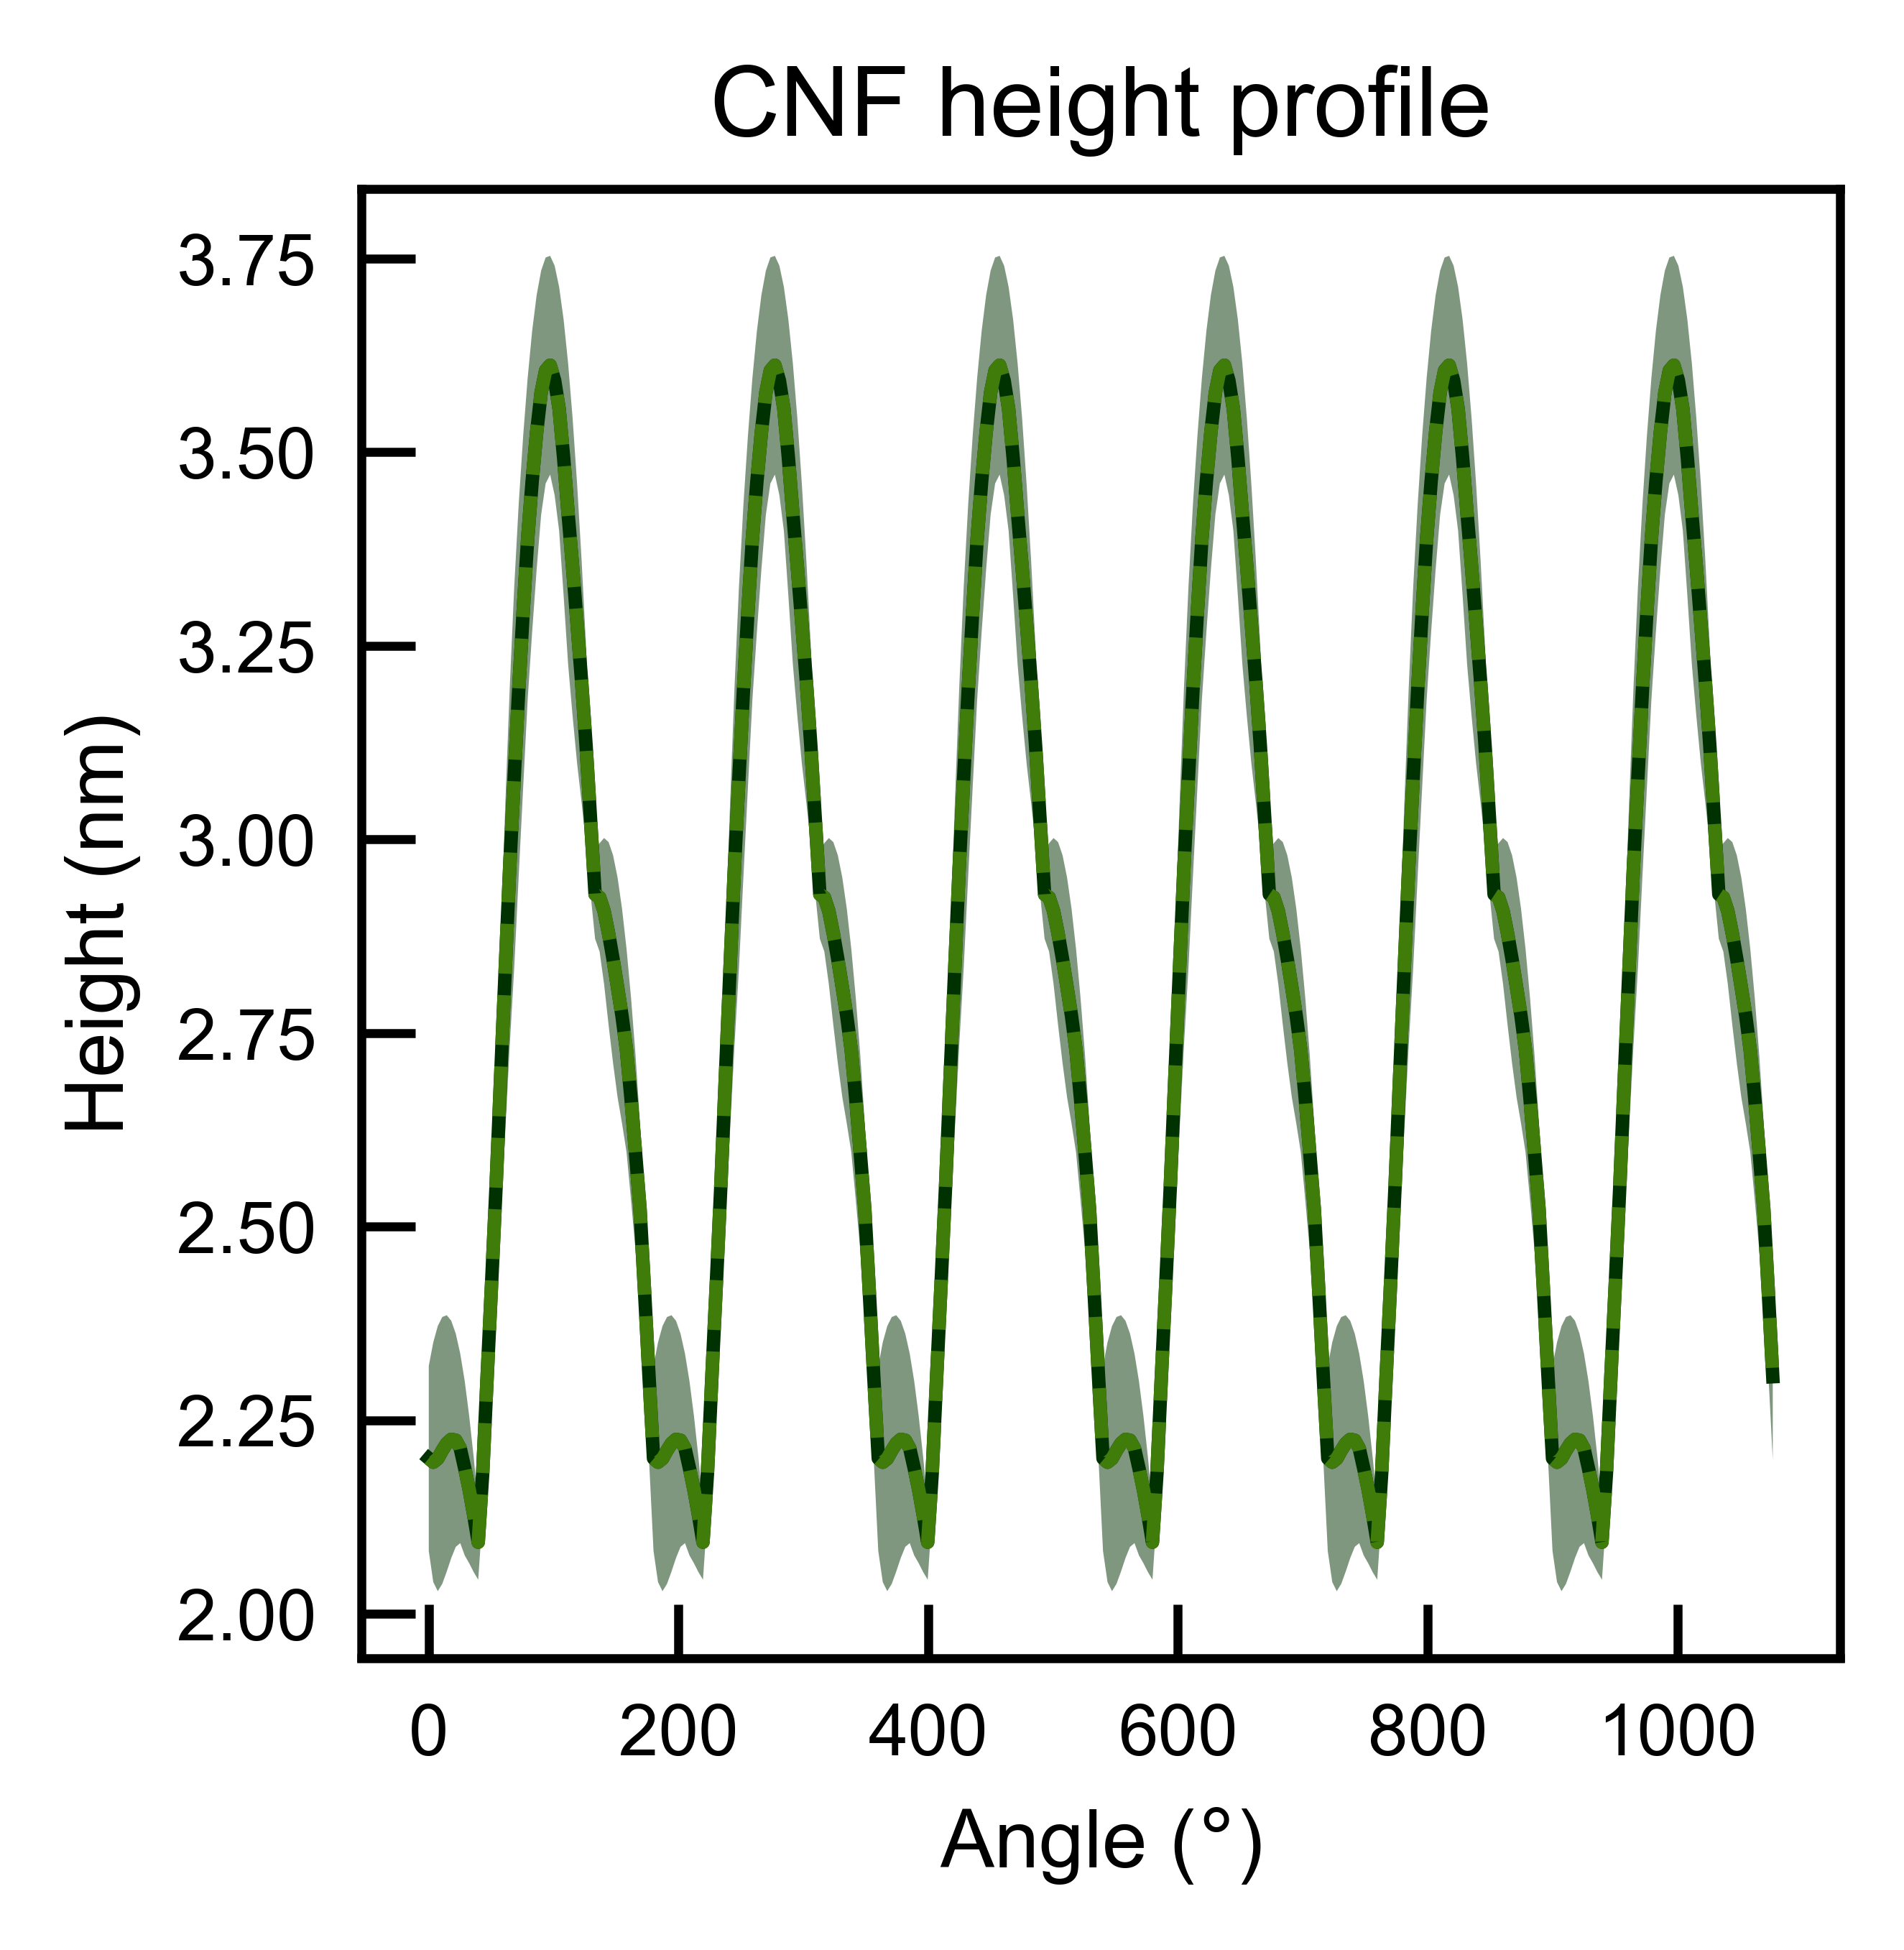

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(angles, mid_heights)
ax.plot(angles, f_mid(angles), ls='--')
# ax.plot(angles, f_range(angles), ls='--')
ax.fill_between(angles, mid_heights - height_range / 2, mid_heights + height_range / 2, alpha=0.5)
ax.set_xlabel('Angle ($\\degree$)')
ax.set_ylabel('Height (nm)')
ax.set_title('CNF height profile')
plt.show()

# 試しにウェーブレット変換

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_14103/3557652363.py:47: RuntimeWarning: divide by zero encountered in divide
  sig95 = power / sig95


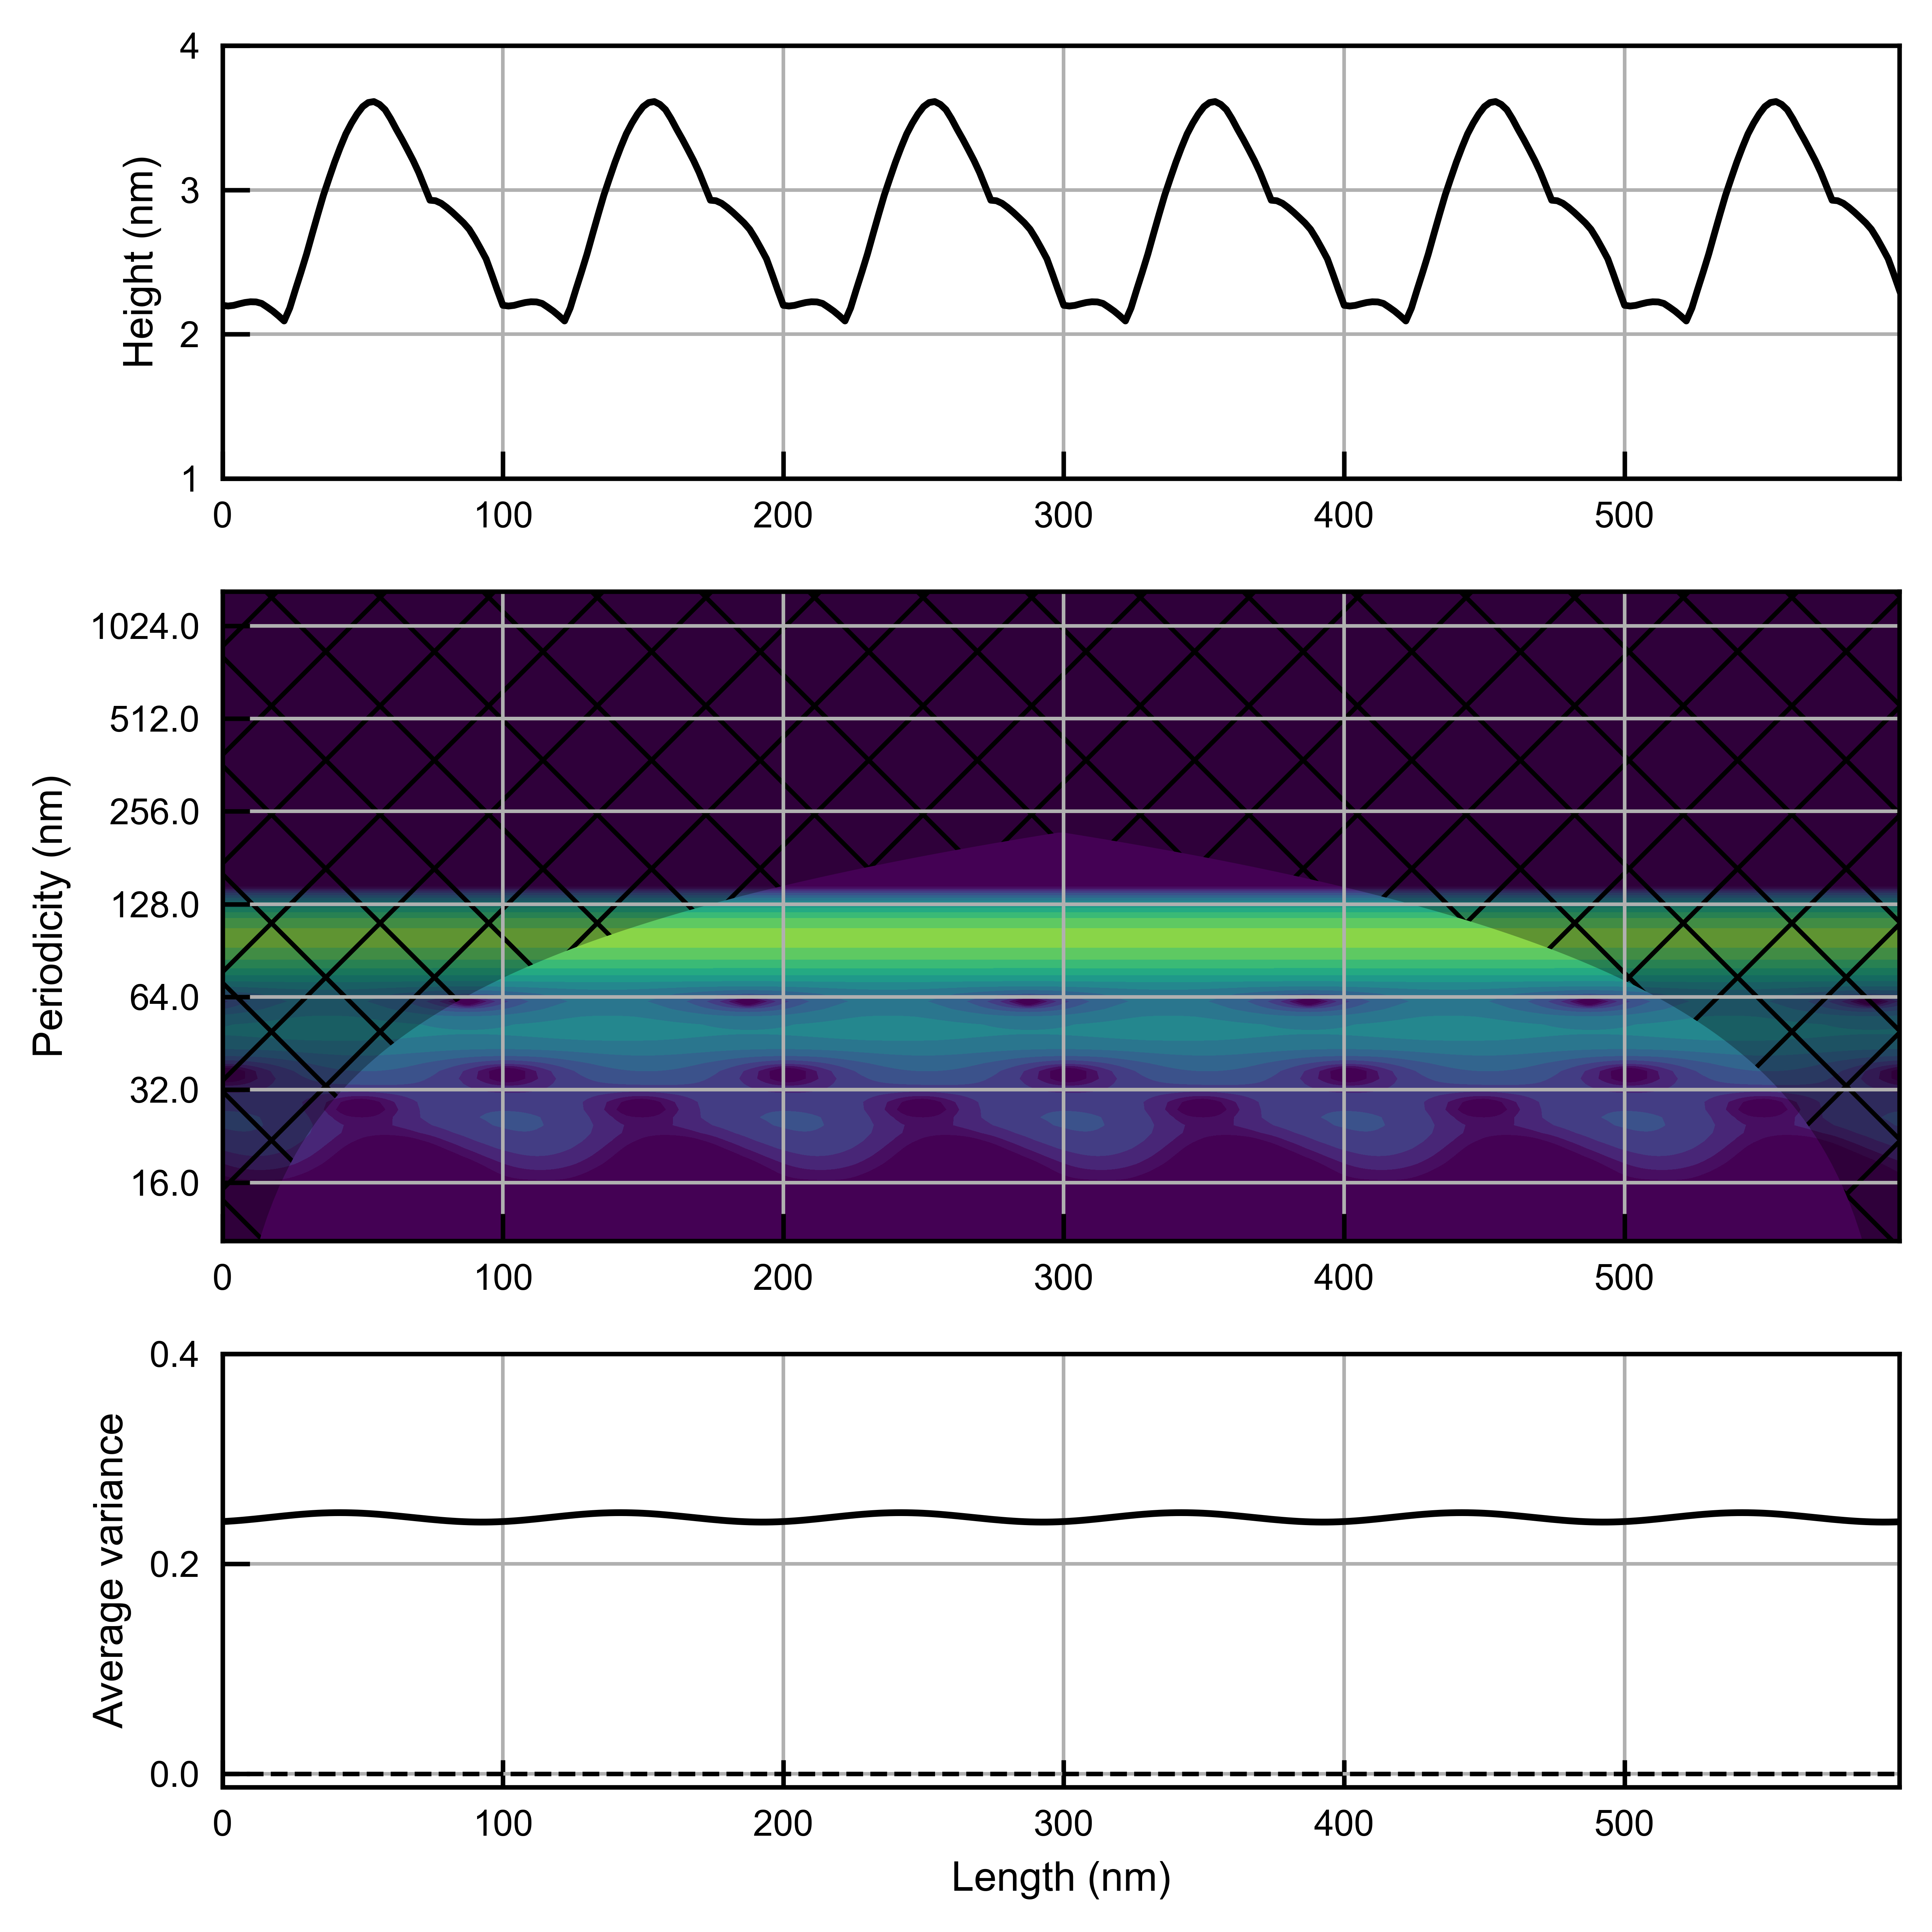

In [5]:
try:
    # dt = 1/1.8 # 1.8 nmごとにデータが取得されているとする(100 nmで180度回転)
    dt = 2
    height = mid_heights
    horizon = np.arange(0, len(height) * dt, dt)

    slevel = 0.95                        # Significance level

    std = height.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    dat = (height - height.mean()) / std       # Calculating anomaly and normalizing
    dat = np.where((-3 < dat) & (dat < 3), dat, 0) # 極端な値を除去
    
    N = dat.size                            # Number of measurements

    dj = 1 / 12 # 1 /  12                     # Twelve sub-octaves per octaves
    s0 = 5 * dt  # 2 * dt                    # Starting scale, here 6 months
    J = 7 / dj  # 7 / dj                     # Seven powers of two with dj sub-octaves
    #  alpha = 0.0                       # Lag-1 autocorrelation for white noise
    try:
        alpha, _, _ = wavelet.ar1(dat)   # Lag-1 autocorrelation for red noise
    except Warning:
        # When the dataset is too short, or there is a strong trend, ar1 raises a
        # warning. In this case, we assume a white noise background spectrum.
        alpha = 1.0

    mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)

    # Normalized wavelet and Fourier power spectra
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    avg1, avg2 = (32, 128)                  # Range of periods to average

    # Significance test. Where ratio power/sig95 > 1, power is significant.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=slevel,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Power rectification as of Liu et al. (2007). TODO: confirm if significance
    # test ratio should be calculated first.
    # power /= scales[:, None]

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)

    # Scale average between avg1 and avg2 periods and significance level
    sel = find((period >= avg1) & (period < avg2))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power / scale_avg
    scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)

    fig = plt.figure(figsize=(6, 6))
    # gs = GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[2, 3, 2])
    gs = GridSpec(3, 1, height_ratios=[2, 3, 2])

    ax_nino3 = fig.add_subplot(gs[0, 0])
    ax_wave = fig.add_subplot(gs[1, 0], sharex=ax_nino3)
    # ax_gl_spec = fig.add_subplot(gs[1, 1], sharey=ax_wave)
    ax_scl_avg = fig.add_subplot(gs[2, 0], sharex=ax_nino3)
    # for a in [ax_nino3, ax_wave, ax_gl_spec, ax_scl_avg]:
    for a in [ax_nino3, ax_wave, ax_scl_avg]:
        a.grid(True)

    ax_nino3.plot(horizon, height, 'k', linewidth=1.5)
    ax_nino3.set_ylim(1,4)
    ax_nino3.set_ylabel('Height (nm)')

    # Contour plot wavelet power spectrum
    # ax_wave.set_title('Wavelet Scalogram')
    # levels = np.exp2(np.arange(-5, 6))
    levels = np.exp2(np.arange(-5, 10))
    ax_wave.contourf(horizon, np.log2(period), np.log2(power), np.log2(levels),
                     extend='both', cmap=plt.cm.viridis)
    extent = horizon.min(), horizon.max(), 0, max(period)

    ax_wave.contour(horizon, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                    extent=extent) # 95% significance contour

    ax_wave.fill(np.concatenate([horizon, horizon[-1:] + dt, horizon[-1:] + dt,
                                 horizon[:1] - dt, horizon[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
    # ax_wave.set_title(f'b) {label} Wavelet Power Spectrum ({mother.name})')
    ax_wave.set_ylabel('Periodicity (nm)')
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
    ax_wave.set_yticks(np.log2(Yticks))
    ax_wave.set_yticklabels(Yticks)
    ax_wave.set_ylim(np.log2([period.min(), period.max()]))
    # print(period.max())

    # The global wavelet and Fourier power spectra
    # ax_gl_spec.plot(glbl_signif, np.log2(period), 'k--')
    # ax_gl_spec.plot(std2 * fft_theor, np.log2(period), '--', color='#cccccc')
    # ax_gl_spec.plot(std2 * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc')
    # ax_gl_spec.plot(std2 * glbl_power, np.log2(period), 'k') # todo なんでここでstd2をかけているのか？
    # 
    # ax_gl_spec.set_title('Global Wavelet Spectrum')
    # ax_gl_spec.set_xlim([0, glbl_power.max() + std2])
    # ax_gl_spec.set_ylim(np.log2([period.min(), period.max()]))
    # ax_gl_spec.set_yticks(np.log2(Yticks))
    # ax_gl_spec.set_yticklabels(Yticks)
    # ax_gl_spec.set_xlabel('Power')
    # plt.setp(ax_gl_spec.get_yticklabels(), visible=False)

    # Scale-averaged power spectrum
    ax_scl_avg.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax_scl_avg.plot(horizon, scale_avg, 'k-', linewidth=1.5)
    # ax_scl_avg.set_title(f'{avg1}-{avg2} nm scale-average power')
    ax_scl_avg.set_xlabel('Length (nm)')
    ax_scl_avg.set_ylabel('Average variance')

    ax_scl_avg.set_xlim([horizon.min(), horizon.max()])
    ax_scl_avg.set_yticks(np.arange(0, 0.6, 0.2))

    plt.tight_layout()
    # plt.close()
    plt.show()
except RuntimeWarning:
    print('Divided by zero')

In [15]:
print(period.max())

# 各回転角に対して初期タップ位置がランダムに一つだけ発生するようにする（一様分布）

In [4]:
class AFM_Simulator():
    def __init__(self, model, tip_r=2, tap_dist=2):
        self.model = model
        self.tip_r = tip_r
        self.tap_dist = tap_dist
        '''
        断面モデルの頂点の座標を入力する
        1βの格子座標で(x座標のndarray, y座標のndarray)を自分で入力し、lattice2orthogonalで直交系に変換している
        '''
        self.formation_dict = {
            '18chain_nishiyama': self.lattice2orthogonal(np.array([-0.25, 0.25, 1.5, 1.5, -0.25, -0.75, -2, -2]),
                                                         np.array([-0.25, -0.25, 1, 2, 3.75, 3.75, 2.5, 1.5])),
            '18chain_daicho': self.lattice2orthogonal(np.array([-0.25, 1.25, 2.5, 0.75, -0.75, -2]),
                                                      np.array([-0.25, -0.25, 1, 2.75, 2.75, 1.5])),
            '18chain_daicho_laminated': self.lattice2orthogonal(np.array([-0.25, 1.25, 2.5, 1.75, 0.25, -1]),
                                                                np.array([-0.25, -0.25, 1, 1.75, 1.75, 0.5]))
            }

    @staticmethod
    def lattice2orthogonal(lattice_x, lattice_y):
        '''
        単位はnm
        入力：セルロ―スⅠβ結晶格子を基底とした座標のndarray
        後に回転するとき用に重心を原点に変換
        出力：直交座標のndarray（小数第3位まで）
        '''
        a = 0.8201
        b = 0.7784
        gamma = math.radians(96.5)

        gx = np.mean(lattice_x)
        gy = np.mean(lattice_y)
        x = np.round(a * (lattice_x - gx) + round(math.cos(gamma), 5) * b * (lattice_y - gy), 4)
        y = np.round(round(math.sin(gamma), 5) * b * (lattice_y - gy), 4)
        return x, y

    @staticmethod
    def rotation(x, t, deg=True):
        #ラジアンでも弧度法でも良い(default: 弧度法)
        if deg == True:
            t = np.deg2rad(t)
        a = np.array([[np.cos(t), -np.sin(t)],
                      [np.sin(t), np.cos(t)]])
        if a.ndim > 2 or a.shape[0] != 2:
            a = a.reshape(2, -1)
        ax = np.dot(a, x)
        return ax


    def _simulate_single_scan(self, angle, offset):
        '''
        CNFの回転角と初期のタップ位置を指定した時のシミュレーションを行う。
        半径rの球がCNFに衝突するときの球の中心の軌跡を考える
        球がCNFの
        1. 辺に衝突する場合
           CNFの辺を距離rだけ平行移動させる
        2. 頂点に衝突する場合
           CNFの頂点を中心に半径rの円を考える
        
        Parameters
        ----------
        angle:float or int
            CNFの回転角
        offset: float or int
            初期のタッピング位置
            
        Returns
        -------
        single_scan: List
            タッピング位置に対するCNFの高さ
        '''
        tapping_posi = np.arange(-8 + offset, 8, self.tap_dist)

        coordinate = np.vstack(self.formation_dict[self.model])
        coor_rotated = self.rotation(coordinate, angle)

        cnf_bottom = np.min(coor_rotated[1])
        #0. 辺に衝突する場合の中心が描く直線の軌跡を求める
        edge_vector = np.roll(coor_rotated, shift=-1, axis=1) - coor_rotated
        moves = self.tip_r * self.rotation(edge_vector, -90) / np.linalg.norm(edge_vector, axis=0)  #平行移動の方向

        equations = []  #球の中心が描く直線の方程式
        x_ranges = []  #方程式の定義域
        for i, move in enumerate(moves.T):
            x1, x2 = coor_rotated[0][i] + move[0], np.roll(coor_rotated, shift=-1, axis=1)[0][i] + move[0]
            y1, y2 = coor_rotated[1][i] + move[1], np.roll(coor_rotated, shift=-1, axis=1)[1][i] + move[1]

            x_array = np.array([x1, x2])
            y_array = np.array([y1, y2])
            equation = np.poly1d(np.polyfit(x_array, y_array, 1))
            equations.append(equation)
            x_ranges.append((np.min(x_array), np.max(x_array)))

        #スキャンを1回実行
        single_scan = []
        for x in tapping_posi:
            height_candidate = [0]  #CNFにぶつからなかったら、高さ0

            #1. 辺に衝突する場合
            for equation, x_range in zip(equations, x_ranges):
                if x_range[0] <= x and x <= x_range[1]:
                    height_candidate.append(equation(x) - self.tip_r - cnf_bottom)
            #2. 頂点に衝突する場合
            for vertex in coor_rotated.T:
                if abs(x - vertex[0]) <= self.tip_r:
                    cy = vertex[1] + math.sqrt(self.tip_r ** 2 - (x - vertex[0]) ** 2)
                    height_candidate.append(cy - self.tip_r - cnf_bottom)

            single_scan.append(max(height_candidate))
        return single_scan

    def calc_thin_height(self, angle, offset):
        '''
        simulate_single_scanで得られたシミュレーション結果から、CNFの高さの中央を測定する
        Parameters
        ----------
        angle: float or int
            CNFの回転角
        offset: float or int
            初期のタップ位置

        Returns
        -------
        thin_height: float
            CNFの高さの中央

        '''
        heights_array = np.array(self._simulate_single_scan(angle, offset))
        fiber_heights = heights_array[heights_array > 0]

        if len(fiber_heights) % 2 == 1:
            thin_index = len(fiber_heights) // 2
            thin_height = fiber_heights[thin_index]

        else:
            thin_index = int(len(fiber_heights) / 2)
            thin_height = (fiber_heights[thin_index] + fiber_heights[thin_index - 1]) / 2
        return thin_height

    def show_shape(self, angle):
        '''
        回転角に対するCNFの形状を表示する
        Parameters
        ----------
        angle: float or int
            CNFの回転角 

        Returns
        -------
        coor_rotated: ndarray
            回転したCNFの頂点を表す座標
        '''
        coordinate = np.vstack(self.formation_dict[self.model])
        coordinate = np.hstack((coordinate, coordinate[:, 0:1]))
        coor_rotated = self.rotation(coordinate, angle)
        return coor_rotated
    
    def calc_mid_height_and_range(self, angles):
        '''
        CNFの回転角に対する高さの中央と範囲を計算する
        Parameters
        ----------
        angles: ndarray
            CNFの回転角度。1D arrayか2D array

        Returns
        -------
        mid_heights: ndarray
            与えられた回転角度に対するCNFの中央高さ
        height_ranges: ndarray
            与えられた回転角度に対するCNFの高さの範囲
        '''
        max_heights, min_heights = self.calc_max_and_min_heights(angles)
        mid_heights = (max_heights + min_heights) / 2
        height_ranges = max_heights - min_heights
        return mid_heights, height_ranges

    def calc_max_and_min_heights(self, angles):
        '''
        CNFの回転角に対する最大高さと最小高さを計算する
        Parameters
        ----------
        angles: ndarray
            CNFの回転角度。1D arrayか2D arrayで入力する。
        Returns
        -------
        max_heights: nearray
            与えられた回転角度に対するCNFの最大高さ
        min_heights: ndarray
            与えられた回転角度に対するCNFの最小高さ
        '''
        offsets = np.linspace(0, self.tap_dist, 100)
        if angles.ndim == 1:
            max_heights = []
            min_heights = []
            for angle in angles:
                height_list = []
                for offset in offsets:
                    thin_height = self.calc_thin_height(angle, offset)
                    height_list.append(thin_height)

                max_heights.append(max(height_list))
                min_heights.append(min(height_list))
            return np.array(max_heights), np.array(min_heights)

        if angles.ndim == 2:
            max_heights_mat = []
            min_heights_mat = []
            for angle_row in angles:
                max_heights = []
                min_heights = []
                for angle in angle_row:
                    height_list = []
                    for offset in offsets:
                        thin_height = self.calc_thin_height(angle, offset)
                        height_list.append(thin_height)
                    max_heights.append(max(height_list))
                    min_heights.append(min(height_list))
                max_heights_mat.append(max_heights)
                min_heights_mat.append(min_heights)
            return np.array(max_heights_mat), np.array(min_heights_mat)
        
    def random_offset_scans(self, angles):
        '''
        各回転角に対して初期タップ位置がランダムに一つだけ発生するようにしたシミュレーションを行う。
        Parameters
        ----------
        angles: ndarray
            CNFの回転角度。1D arrayで入力する。
        Returns
        -------
        random_offsets: ndarray
            各回転角に対するランダムな初期タップ位置
        '''
        random_offsets = np.random.uniform(0, self.tap_dist, len(angles))
        scans = []
        for angle, offset in zip(angles, random_offsets):
            scans.append(self.calc_thin_height(angle, offset))
        return np.array(scans)
        

# 無傷のCNFの場合

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/22397

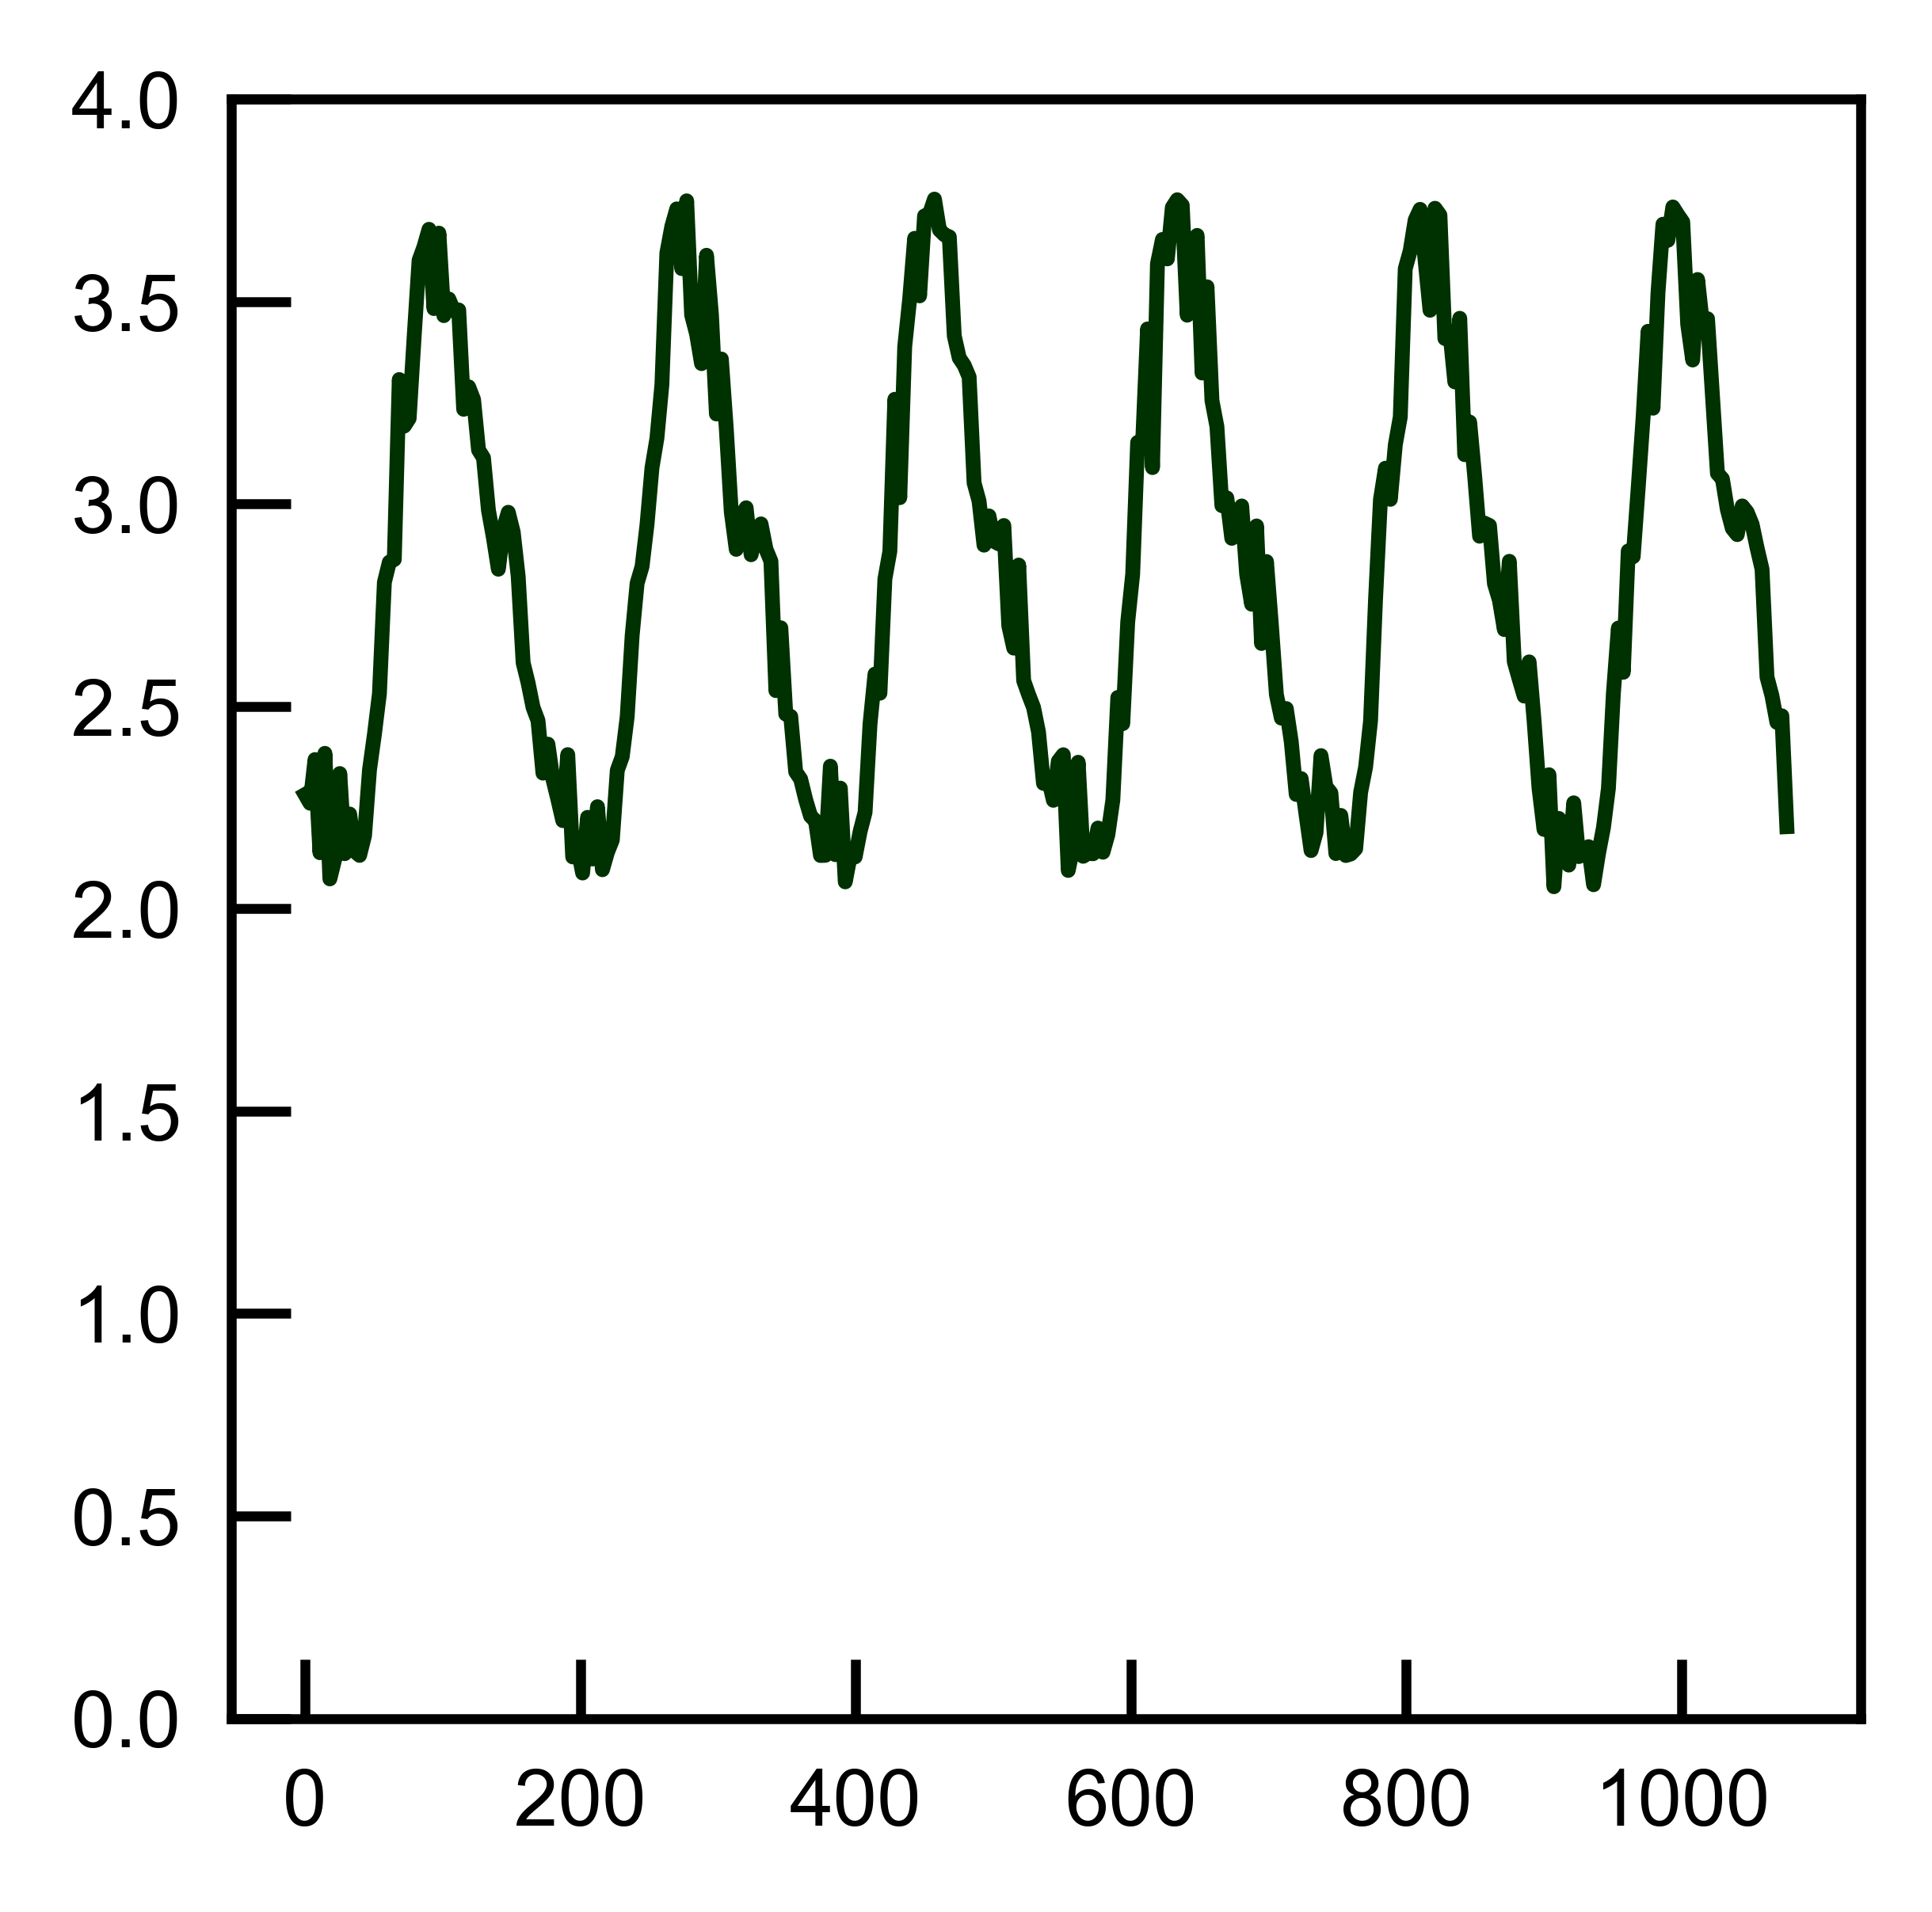

In [8]:
afm_sim = AFM_Simulator('18chain_daicho')
angles = np.arange(0, 1080, 3.6)
scans = afm_sim.random_offset_scans(angles)

fig, ax = plt.subplots(1, 1)
ax.plot(angles, scans)
ax.set_ylim(0, 4)
# plt.savefig(f'./beautiful_plot.svg')

plt.show()

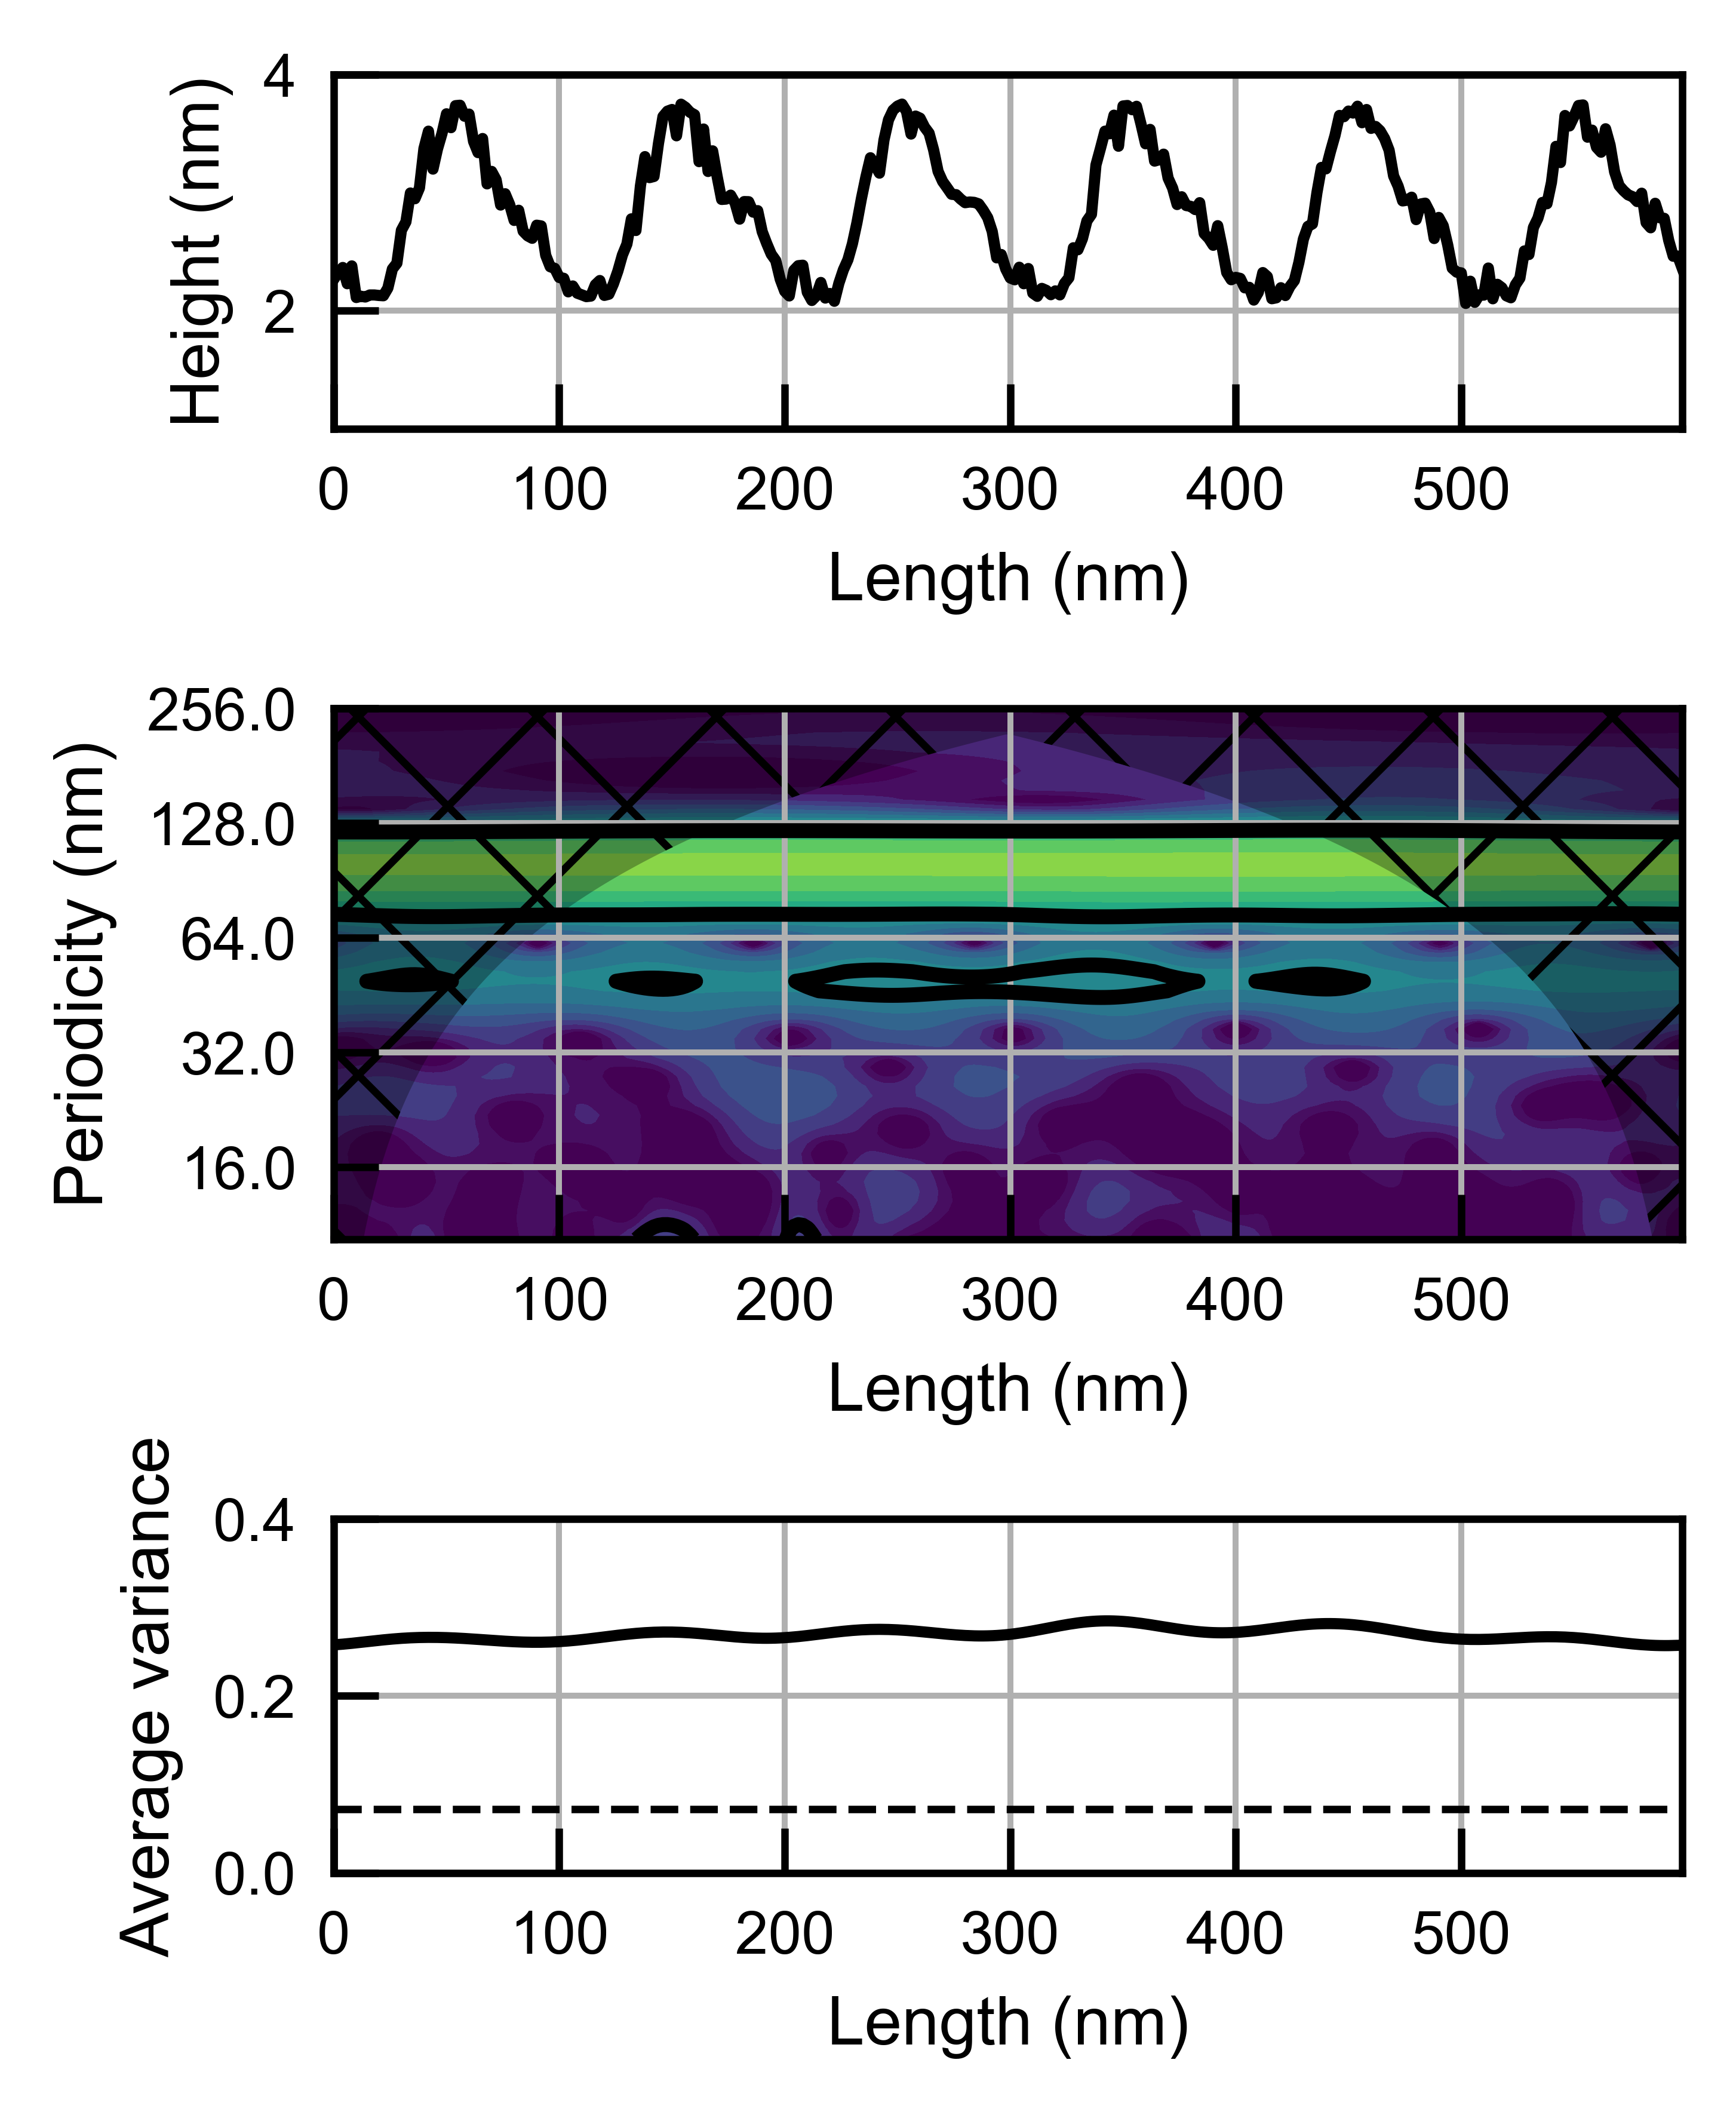

In [6]:
try:
    # dt = 1/1.8 # 1.8 nmごとにデータが取得されているとする(100 nmで180度回転)
    dt = 2
    height = scans
    horizon = np.arange(0, len(height) * dt, dt)

    slevel = 0.95                        # Significance level

    std = height.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    dat = (height - height.mean()) / std       # Calculating anomaly and normalizing
    dat = np.where((-3 < dat) & (dat < 3), dat, 0) # 極端な値を除去
    
    N = dat.size                            # Number of measurements

    dj = 1 / 12 # 1 /  12                     # Twelve sub-octaves per octaves
    s0 = 5 * dt  # 2 * dt                    # Starting scale, here 6 months
    J = 7 / dj  # 7 / dj                     # Seven powers of two with dj sub-octaves
    #  alpha = 0.0                       # Lag-1 autocorrelation for white noise
    try:
        alpha, _, _ = wavelet.ar1(dat)   # Lag-1 autocorrelation for red noise
    except Warning:
        # When the dataset is too short, or there is a strong trend, ar1 raises a
        # warning. In this case, we assume a white noise background spectrum.
        alpha = 1.0

    mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)

    # Normalized wavelet and Fourier power spectra
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    avg1, avg2 = (32, 128)                  # Range of periods to average

    # Significance test. Where ratio power/sig95 > 1, power is significant.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=slevel,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Power rectification as of Liu et al. (2007). TODO: confirm if significance
    # test ratio should be calculated first.
    # power /= scales[:, None]

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)

    # Scale average between avg1 and avg2 periods and significance level
    sel = find((period >= avg1) & (period < avg2))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power / scale_avg
    scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)

    fig = plt.figure(figsize=(3.3, 4))
    # gs = GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[2, 3, 2])
    gs = GridSpec(3, 1, height_ratios=[2, 3, 2])

    ax_nino3 = fig.add_subplot(gs[0, 0])
    ax_wave = fig.add_subplot(gs[1, 0], sharex=ax_nino3)
    # ax_gl_spec = fig.add_subplot(gs[1, 1], sharey=ax_wave)
    ax_scl_avg = fig.add_subplot(gs[2, 0], sharex=ax_nino3)
    # for a in [ax_nino3, ax_wave, ax_gl_spec, ax_scl_avg]:
    for a in [ax_nino3, ax_wave, ax_scl_avg]:
        a.grid(True)

    ax_nino3.plot(horizon, height, 'k', linewidth=1.5)
    ax_nino3.set_ylim(1,4)
    ax_nino3.set_ylabel('Height (nm)')
    ax_nino3.set_xlabel('Length (nm)')

    # Contour plot wavelet power spectrum
    # ax_wave.set_title('Wavelet Scalogram')
    # levels = np.exp2(np.arange(-5, 6))
    levels = np.exp2(np.arange(-5, 10))
    ax_wave.contourf(horizon, np.log2(period), np.log2(power), np.log2(levels),
                     extend='both', cmap=plt.cm.viridis)
    extent = horizon.min(), horizon.max(), 0, max(period)

    ax_wave.contour(horizon, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                    extent=extent) # 95% significance contour

    ax_wave.fill(np.concatenate([horizon, horizon[-1:] + dt, horizon[-1:] + dt,
                                 horizon[:1] - dt, horizon[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
    # ax_wave.set_title(f'b) {label} Wavelet Power Spectrum ({mother.name})')
    ax_wave.set_ylabel('Periodicity (nm)')
    ax_wave.set_xlabel('Length (nm)')
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
    ax_wave.set_yticks(np.log2(Yticks))
    ax_wave.set_yticklabels(Yticks)
    # ax_wave.set_ylim(np.log2([period.min(), period.max()]))
    ax_wave.set_ylim(np.log2([period.min(), 256]))
    # print(period.max())

    # The global wavelet and Fourier power spectra
    # ax_gl_spec.plot(glbl_signif, np.log2(period), 'k--')
    # ax_gl_spec.plot(std2 * fft_theor, np.log2(period), '--', color='#cccccc')
    # ax_gl_spec.plot(std2 * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc')
    # ax_gl_spec.plot(std2 * glbl_power, np.log2(period), 'k') # todo なんでここでstd2をかけているのか？
    # 
    # ax_gl_spec.set_title('Global Wavelet Spectrum')
    # ax_gl_spec.set_xlim([0, glbl_power.max() + std2])
    # ax_gl_spec.set_ylim(np.log2([period.min(), period.max()]))
    # ax_gl_spec.set_yticks(np.log2(Yticks))
    # ax_gl_spec.set_yticklabels(Yticks)
    # ax_gl_spec.set_xlabel('Power')
    # plt.setp(ax_gl_spec.get_yticklabels(), visible=False)

    # Scale-averaged power spectrum
    ax_scl_avg.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax_scl_avg.plot(horizon, scale_avg, 'k-', linewidth=1.5)
    # ax_scl_avg.set_title(f'{avg1}-{avg2} nm scale-average power')
    ax_scl_avg.set_xlabel('Length (nm)')
    ax_scl_avg.set_ylabel('Average variance')

    ax_scl_avg.set_xlim([horizon.min(), horizon.max()])
    ax_scl_avg.set_yticks(np.arange(0, 0.6, 0.2))

    plt.tight_layout()
    # plt.close()
    image_dir = Path(f'./Figure/Distorted_wavelet/')
    if not image_dir.exists():
        image_dir.mkdir(parents=True)
    # plt.savefig(image_dir / 'intact_wavelet.png', dpi=900)
    
    plt.show()
except RuntimeWarning:
    print('Divided by zero')

# 分子シートが削られたバージョンの高さを40％の確率で発生させる

## 削られた確率が100%の場合の高さプロファイル

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/2239729031.py:90: RankWarning: Polyfit may be poorly conditioned
  equation = np.poly1d(np.polyfit(x_array, y_array, 1))
/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_45627/22397

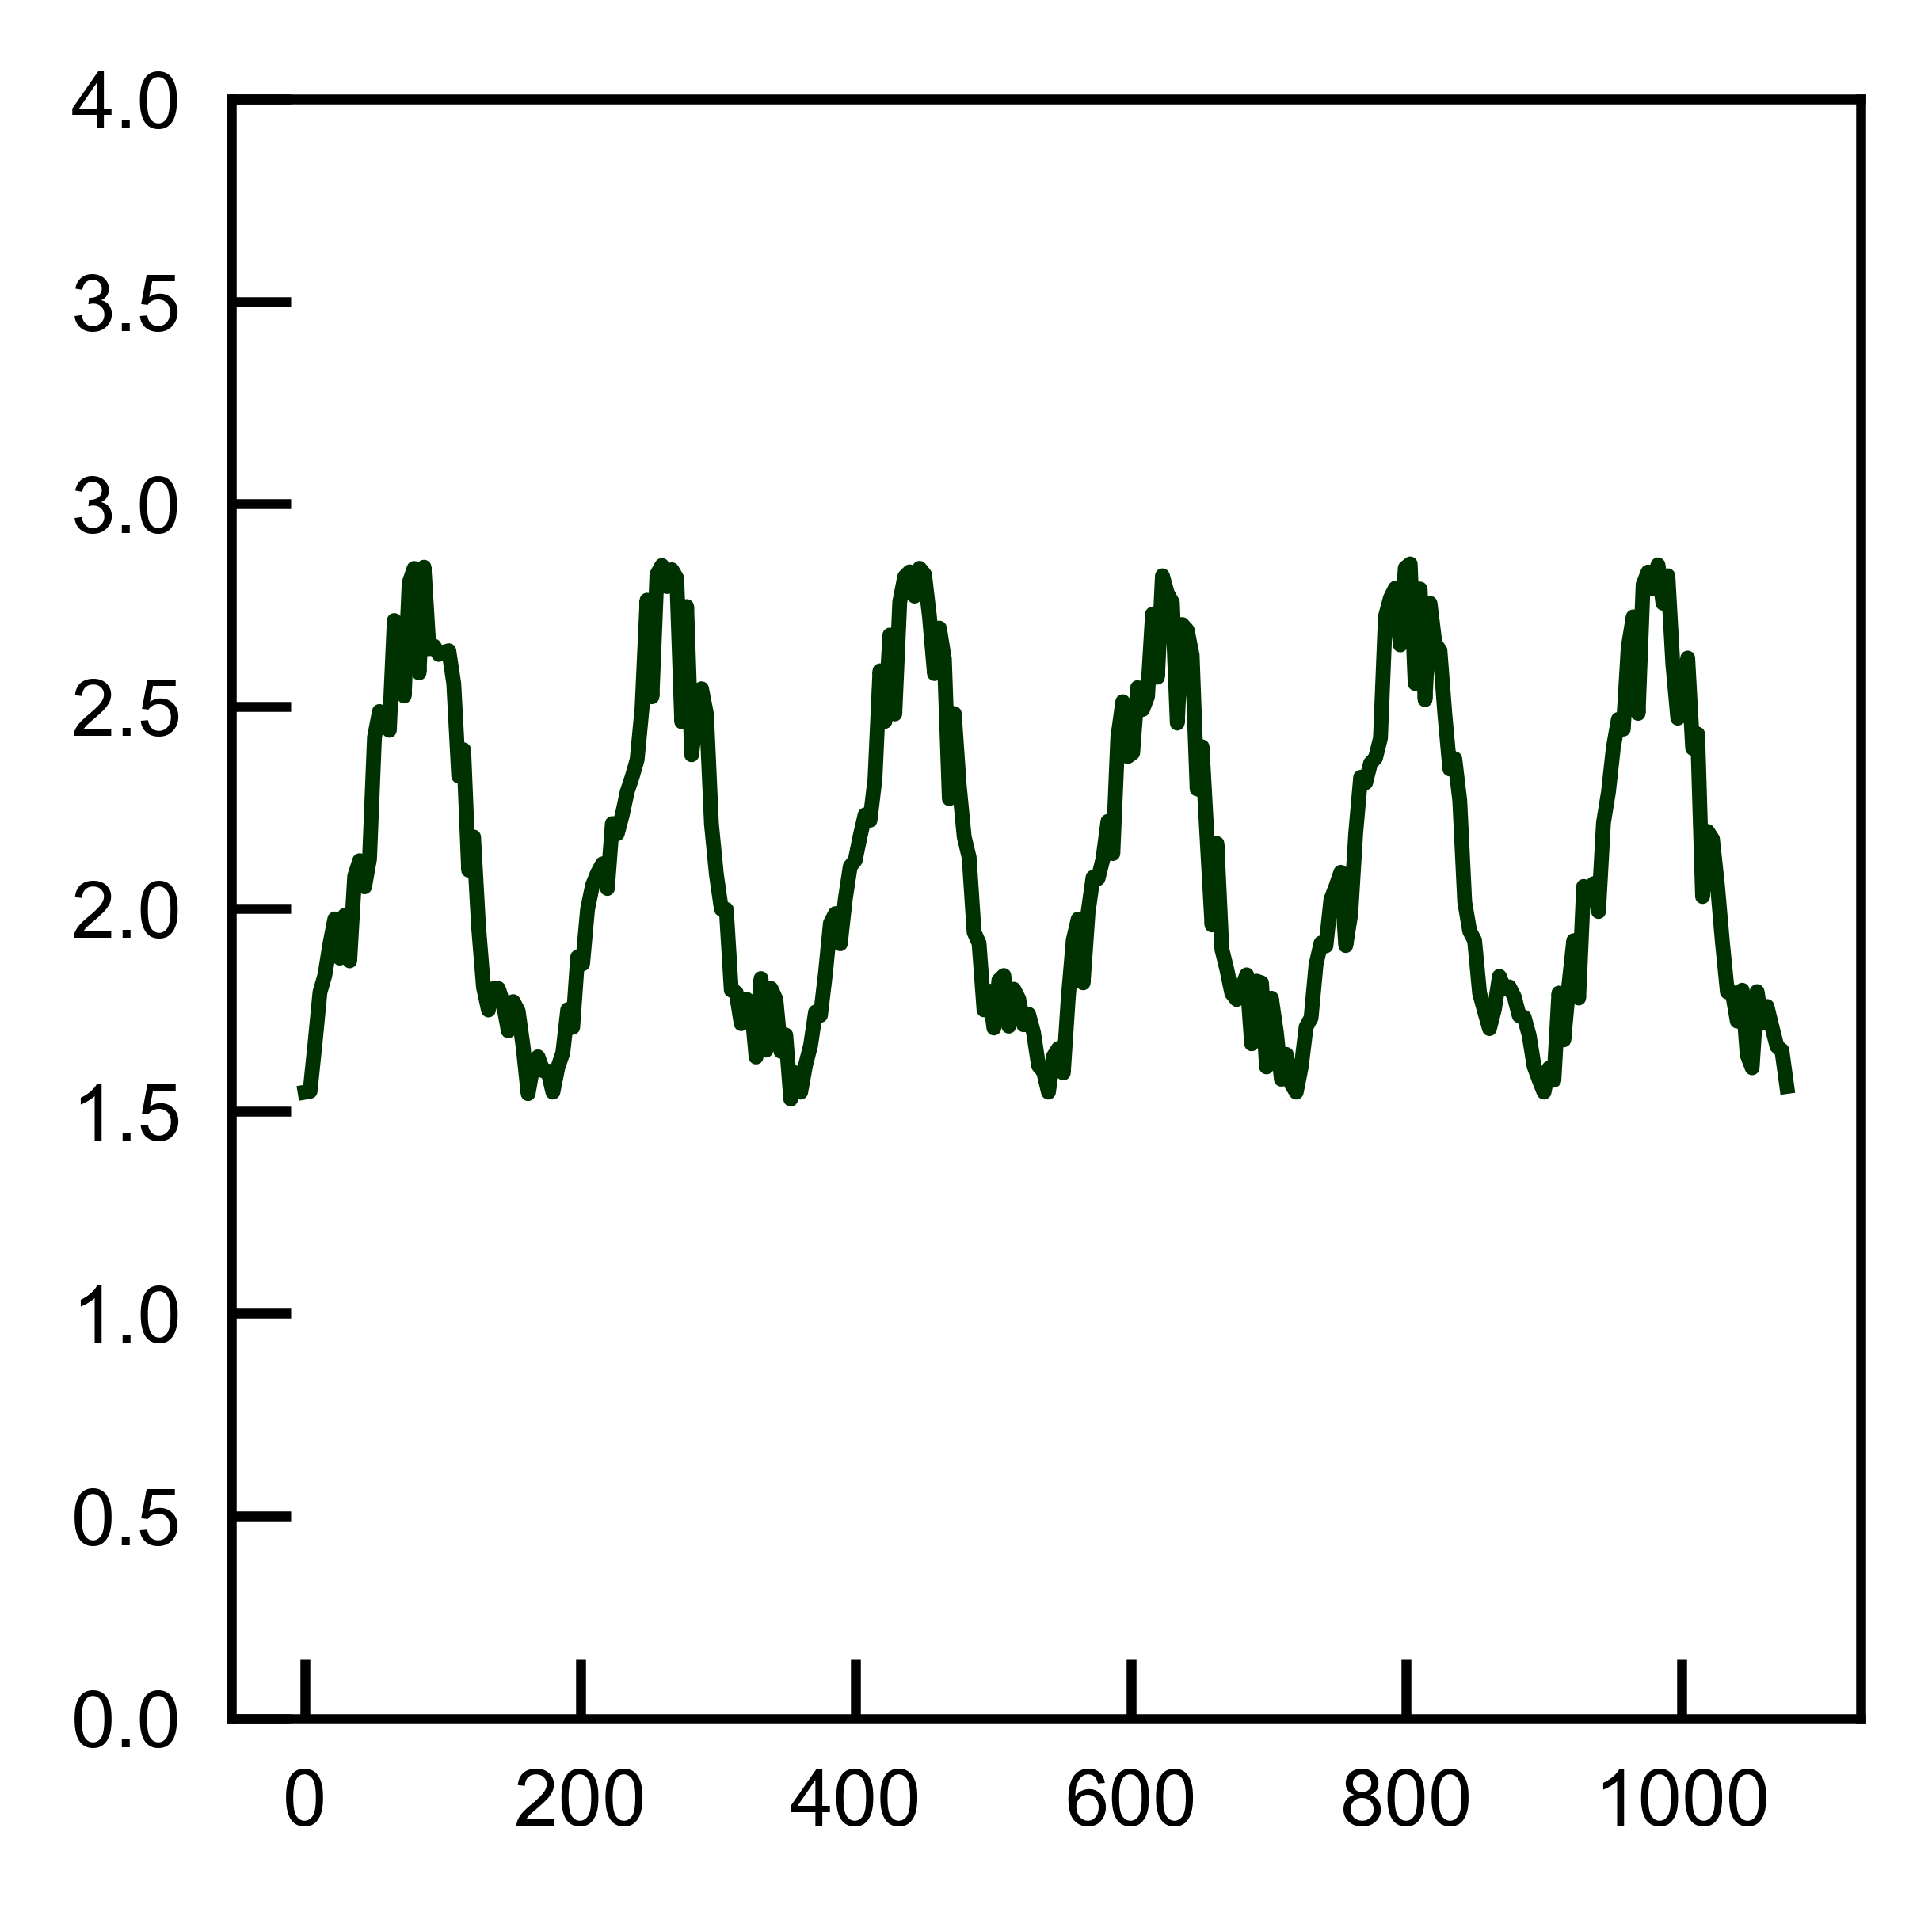

In [7]:
afm_sim = AFM_Simulator('18chain_daicho_laminated')
angles = np.arange(0, 1080, 3.6)
scans_laminated = afm_sim.random_offset_scans(angles)

fig, ax = plt.subplots(1, 1)
ax.plot(angles, scans_laminated)
ax.set_ylim(0, 4)
plt.show()

## 分子シートが削られたバージョンの高さを40％の確率で発生させる

In [20]:
binary_array = np.random.choice([True, False], size=angles.size, p=[0.6, 0.4]) # True: 削られていない, False: 削られている

height_array = np.where(binary_array, scans, scans_laminated)

In [21]:
print(binary_array)

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(angles, height_array)
ax.set_ylim(0, 4)
plt.show()

## 0が最低5回以上連続して出現するようなシーケンスを生成する
これだと0が必ず5回だけ連続するので、それ以外の連続部分の長さもランダムに生成するようにする

In [12]:
def generate_sequence(N, min_zero_run_length=5):
    zeros_needed = int(0.4 * N)
    ones_needed = N - zeros_needed

    # 0の連続部分の可能な最大数を計算
    max_zero_runs = zeros_needed // min_zero_run_length
    if max_zero_runs == 0:
        zero_runs = 1
    else:
        # 0の連続部分の数を1から最大数までのランダムな整数で決定
        zero_runs = np.random.randint(1, max_zero_runs + 1)

    # 各0の連続部分の初期長さを設定
    zero_run_lengths = [min_zero_run_length] * zero_runs
    remaining_zeros = zeros_needed - (min_zero_run_length * zero_runs)

    if remaining_zeros > 0:
        # 残りの0をランダムに分配
        extra_zeros = np.random.multinomial(remaining_zeros, [1/zero_runs]*zero_runs)
        zero_run_lengths = [length + extra for length, extra in zip(zero_run_lengths, extra_zeros)]

    # シーケンスの開始を0または1でランダムに決定
    start_with_zero = np.random.choice([True, False])

    if start_with_zero:
        one_runs = zero_runs - 1
    else:
        one_runs = zero_runs + 1

    # 各1の連続部分の初期長さを設定
    if one_runs > 0:
        min_one_run_length = 1
        one_run_lengths = [min_one_run_length] * one_runs
        remaining_ones = ones_needed - (min_one_run_length * one_runs)

        if remaining_ones > 0:
            # 残りの1をランダムに分配
            extra_ones = np.random.multinomial(remaining_ones, [1/one_runs]*one_runs)
            one_run_lengths = [length + extra for length, extra in zip(one_run_lengths, extra_ones)]
    else:
        one_run_lengths = []

    # シーケンスを構築
    sequence = []
    if start_with_zero:
        for i in range(zero_runs):
            sequence.extend([0] * zero_run_lengths[i])
            if i < one_runs:
                sequence.extend([1] * one_run_lengths[i])
    else:
        for i in range(one_runs):
            sequence.extend([1] * one_run_lengths[i])
            if i < zero_runs:
                sequence.extend([0] * zero_run_lengths[i])

    # シーケンスをndarrayに変換
    sequence = np.array(sequence)

    # シーケンスの長さを調整
    if len(sequence) < N:
        sequence = np.append(sequence, [1] * (N - len(sequence)))
    elif len(sequence) > N:
        sequence = sequence[:N]

    return sequence

In [13]:
N = angles.size
sequence = generate_sequence(N).astype(bool)
print(sequence)
print(f"0の割合: {np.mean(sequence == 0) * 100}%")

[False False False False False False  True  True  True  True  True  True
  True False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False  True  True  True  True  True  True  True  T

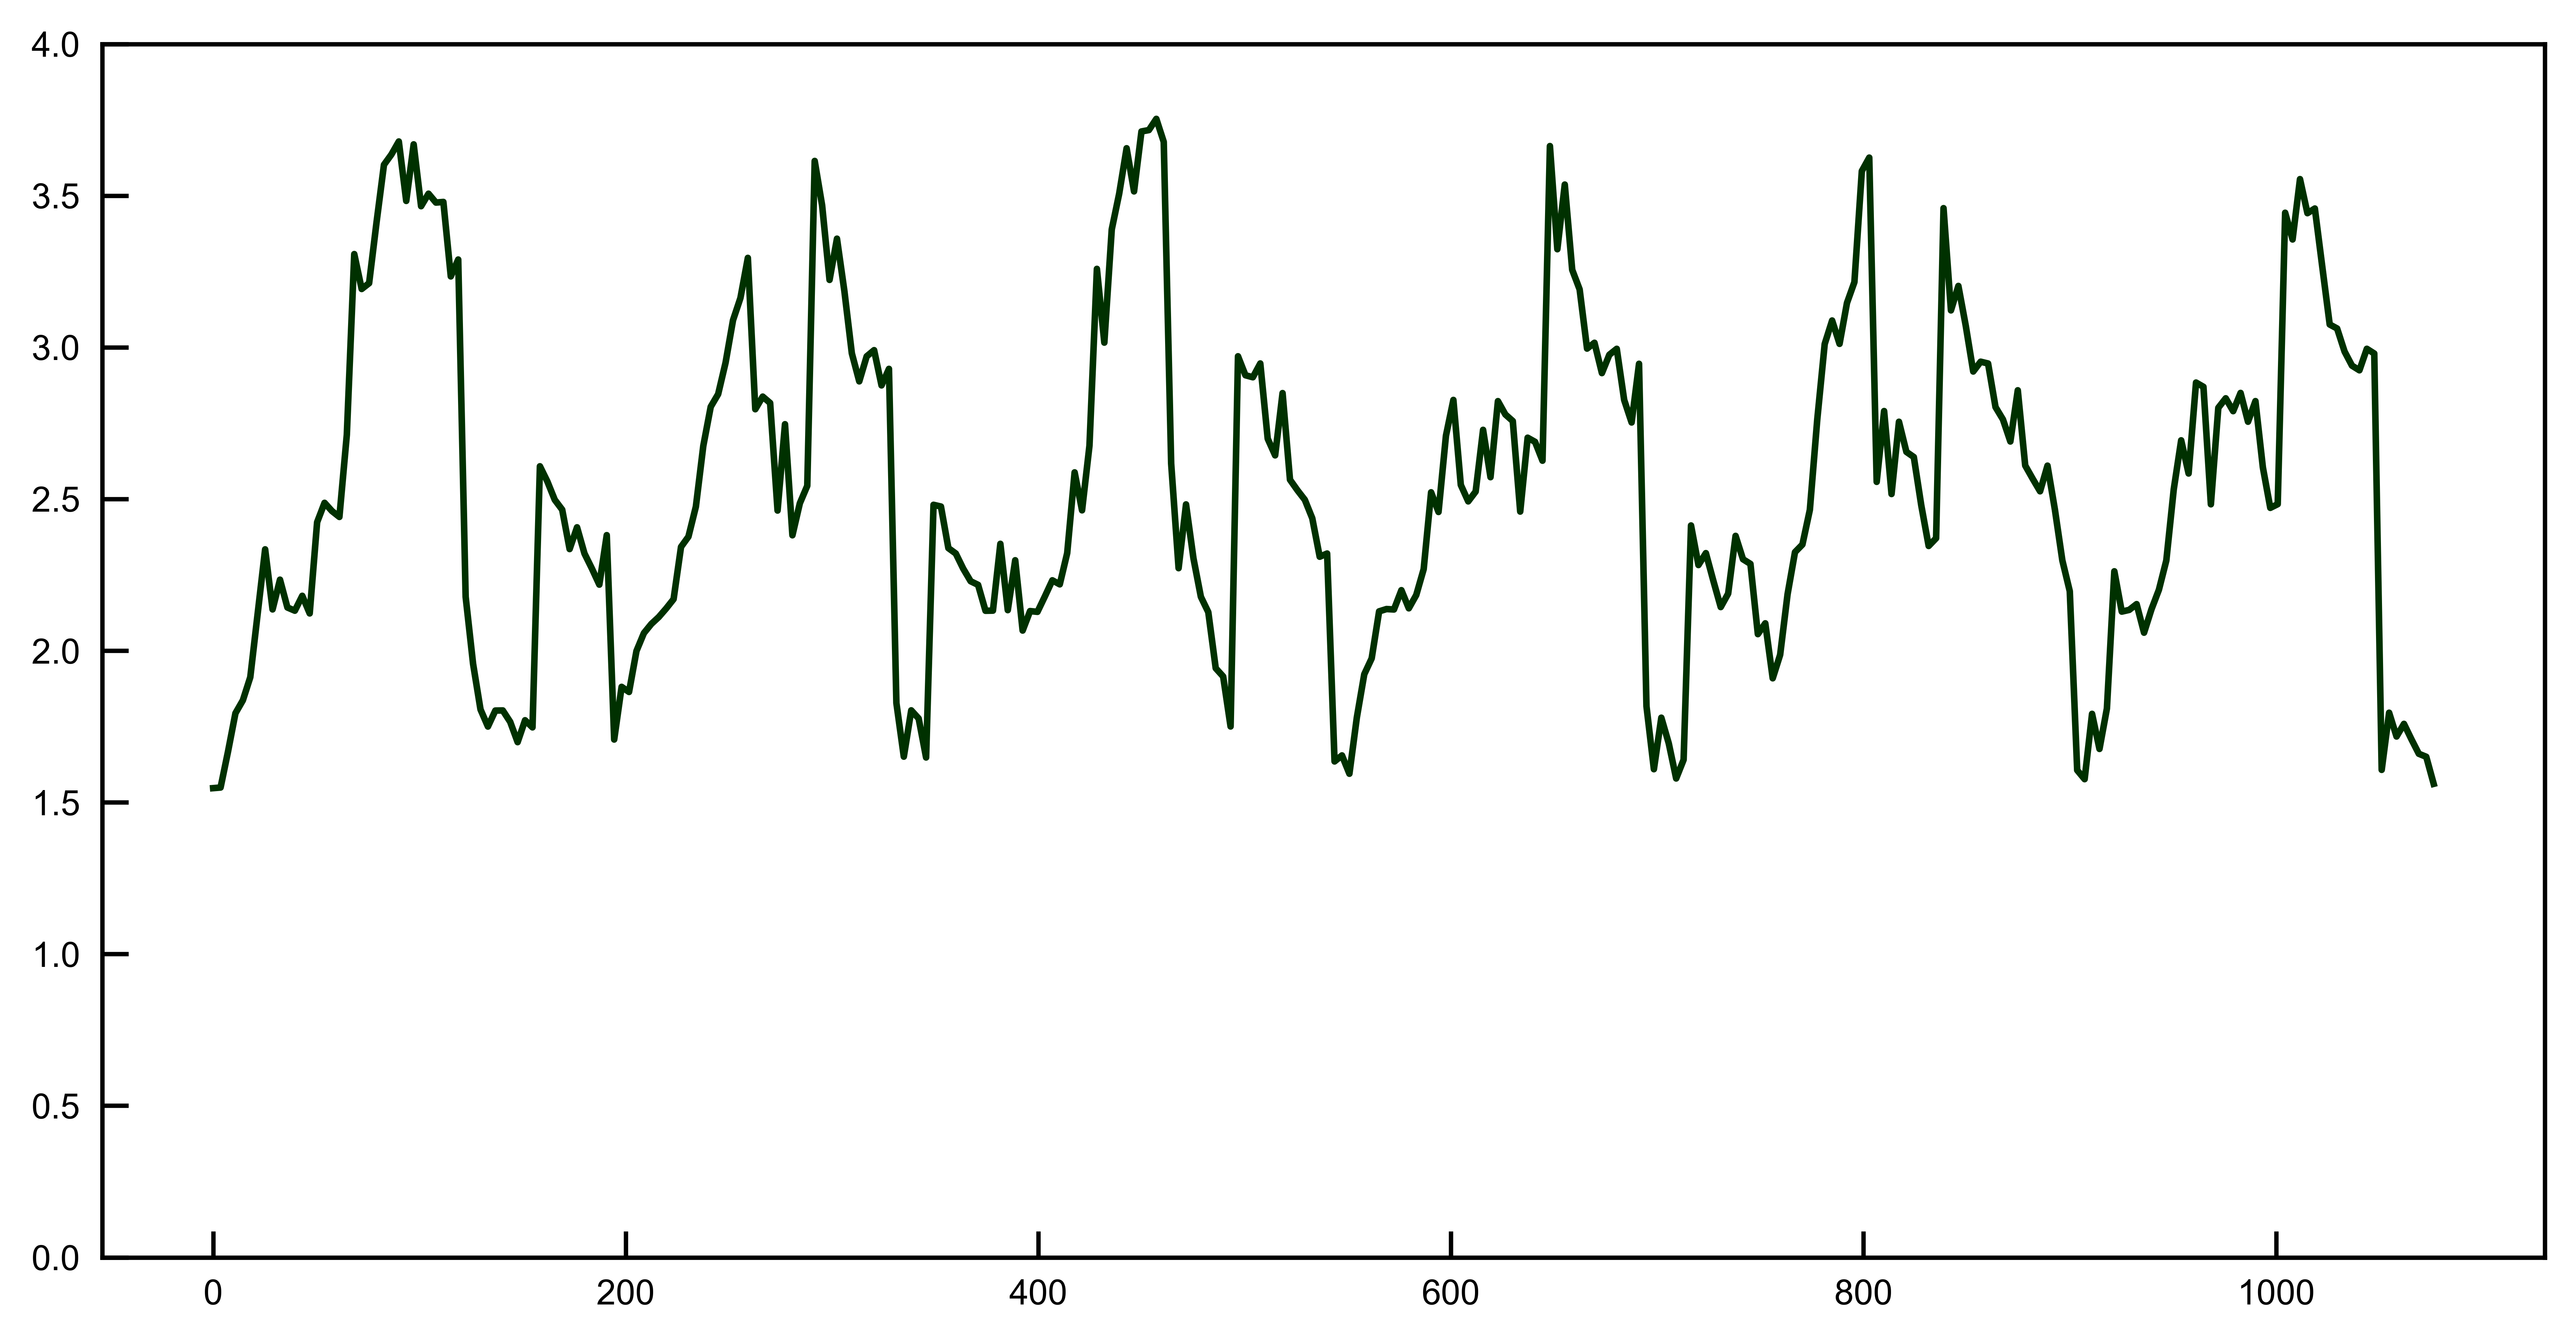

In [14]:
height_array = np.where(sequence, scans, scans_laminated)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(angles, height_array)
ax.set_ylim(0, 4)
plt.show()

In [15]:
def compute_zero_run_lengths(sequence):
    # シーケンスの値の変化点を見つける
    diff = np.diff(sequence)
    idx = np.where(diff != 0)[0] + 1
    # 開始位置と終了位置のインデックスを取得
    idx = np.concatenate(([0], idx, [len(sequence)]))
    # 各ランの長さを計算
    run_lengths = np.diff(idx)
    # 各ランの値を取得
    run_values = sequence[idx[:-1]]
    # 0のランの長さを抽出
    zero_run_lengths = run_lengths[run_values == 0]
    return zero_run_lengths

In [16]:
# 0の連続部分の長さを計算
zero_run_lengths = compute_zero_run_lengths(sequence)

# 最小値と最大値を取得
min_zero_run_length = np.min(zero_run_lengths)
max_zero_run_length = np.max(zero_run_lengths)

print(f"0の連続部分の最小長さ: {min_zero_run_length}")
print(f"0の連続部分の最大長さ: {max_zero_run_length}")

0の連続部分の最小長さ: 5
0の連続部分の最大長さ: 12


## 0が最低5回以上連続して出現するようなシーケンスを生成する（改良バージョン）

In [17]:
def generate_sequence(sequence_length, zero_ratio, min_zero_run_length):
    # 0の割合を計算
    zero_count = int(sequence_length * zero_ratio)
    one_count = sequence_length - zero_count

    # 0の連続部分の可能な最大数を計算
    max_zero_runs = zero_count // min_zero_run_length
    if max_zero_runs == 0:
        zero_runs = 1
    else:
        # 0の連続部分の数を1から最大数までのランダムな整数で決定
        zero_runs = np.random.randint(1, max_zero_runs + 1)

    # 各0の連続部分の初期長さを設定
    zero_run_lengths = [min_zero_run_length] * zero_runs
    remaining_zeros = zero_count - (min_zero_run_length * zero_runs)

    if remaining_zeros > 0:
        # 残りの0をランダムに分配
        extra_zeros = np.random.multinomial(remaining_zeros, [1/zero_runs]*zero_runs)
        zero_run_lengths = [length + extra for length, extra in zip(zero_run_lengths, extra_zeros)]

    # シーケンスの開始を0または1でランダムに決定
    start_with_zero = np.random.choice([True, False])

    if start_with_zero:
        one_runs = zero_runs - 1
    else:
        one_runs = zero_runs + 1

    # 各1の連続部分の初期長さを設定
    if one_runs > 0:
        min_one_run_length = 1
        one_run_lengths = [min_one_run_length] * one_runs
        remaining_ones = one_count - (min_one_run_length * one_runs)

        if remaining_ones > 0:
            # 残りの1をランダムに分配
            extra_ones = np.random.multinomial(remaining_ones, [1/one_runs]*one_runs)
            one_run_lengths = [length + extra for length, extra in zip(one_run_lengths, extra_ones)]
    else:
        one_run_lengths = []

    # シーケンスを構築
    sequence = []
    if start_with_zero:
        for i in range(zero_runs):
            sequence.extend([0] * zero_run_lengths[i])
            if i < one_runs:
                sequence.extend([1] * one_run_lengths[i])
    else:
        for i in range(one_runs):
            sequence.extend([1] * one_run_lengths[i])
            if i < zero_runs:
                sequence.extend([0] * zero_run_lengths[i])
                
    # シーケンスをndarrayに変換
    sequence = np.array(sequence)
    
    # シーケンスの長さを調整
    if len(sequence) < sequence_length:
        sequence = np.append(sequence, [1] * (sequence_length - len(sequence)))
    elif len(sequence) > sequence_length:
        sequence = sequence[:sequence_length]
        
    return sequence

In [18]:
N = angles.size
sequence = generate_sequence(N, 0.4, 5).astype(bool)
print(sequence)
print(f"0の割合: {np.mean(sequence == 0) * 100}%")
# 0の連続部分の長さを計算
zero_run_lengths = compute_zero_run_lengths(sequence)

# 最小値と最大値を取得
min_zero_run_length = np.min(zero_run_lengths)
max_zero_run_length = np.max(zero_run_lengths)

print(f"0の連続部分の最小長さ: {min_zero_run_length}")
print(f"0の連続部分の最大長さ: {max_zero_run_length}")

[False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False  True  True  True  True  True  True  True  True
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False  T

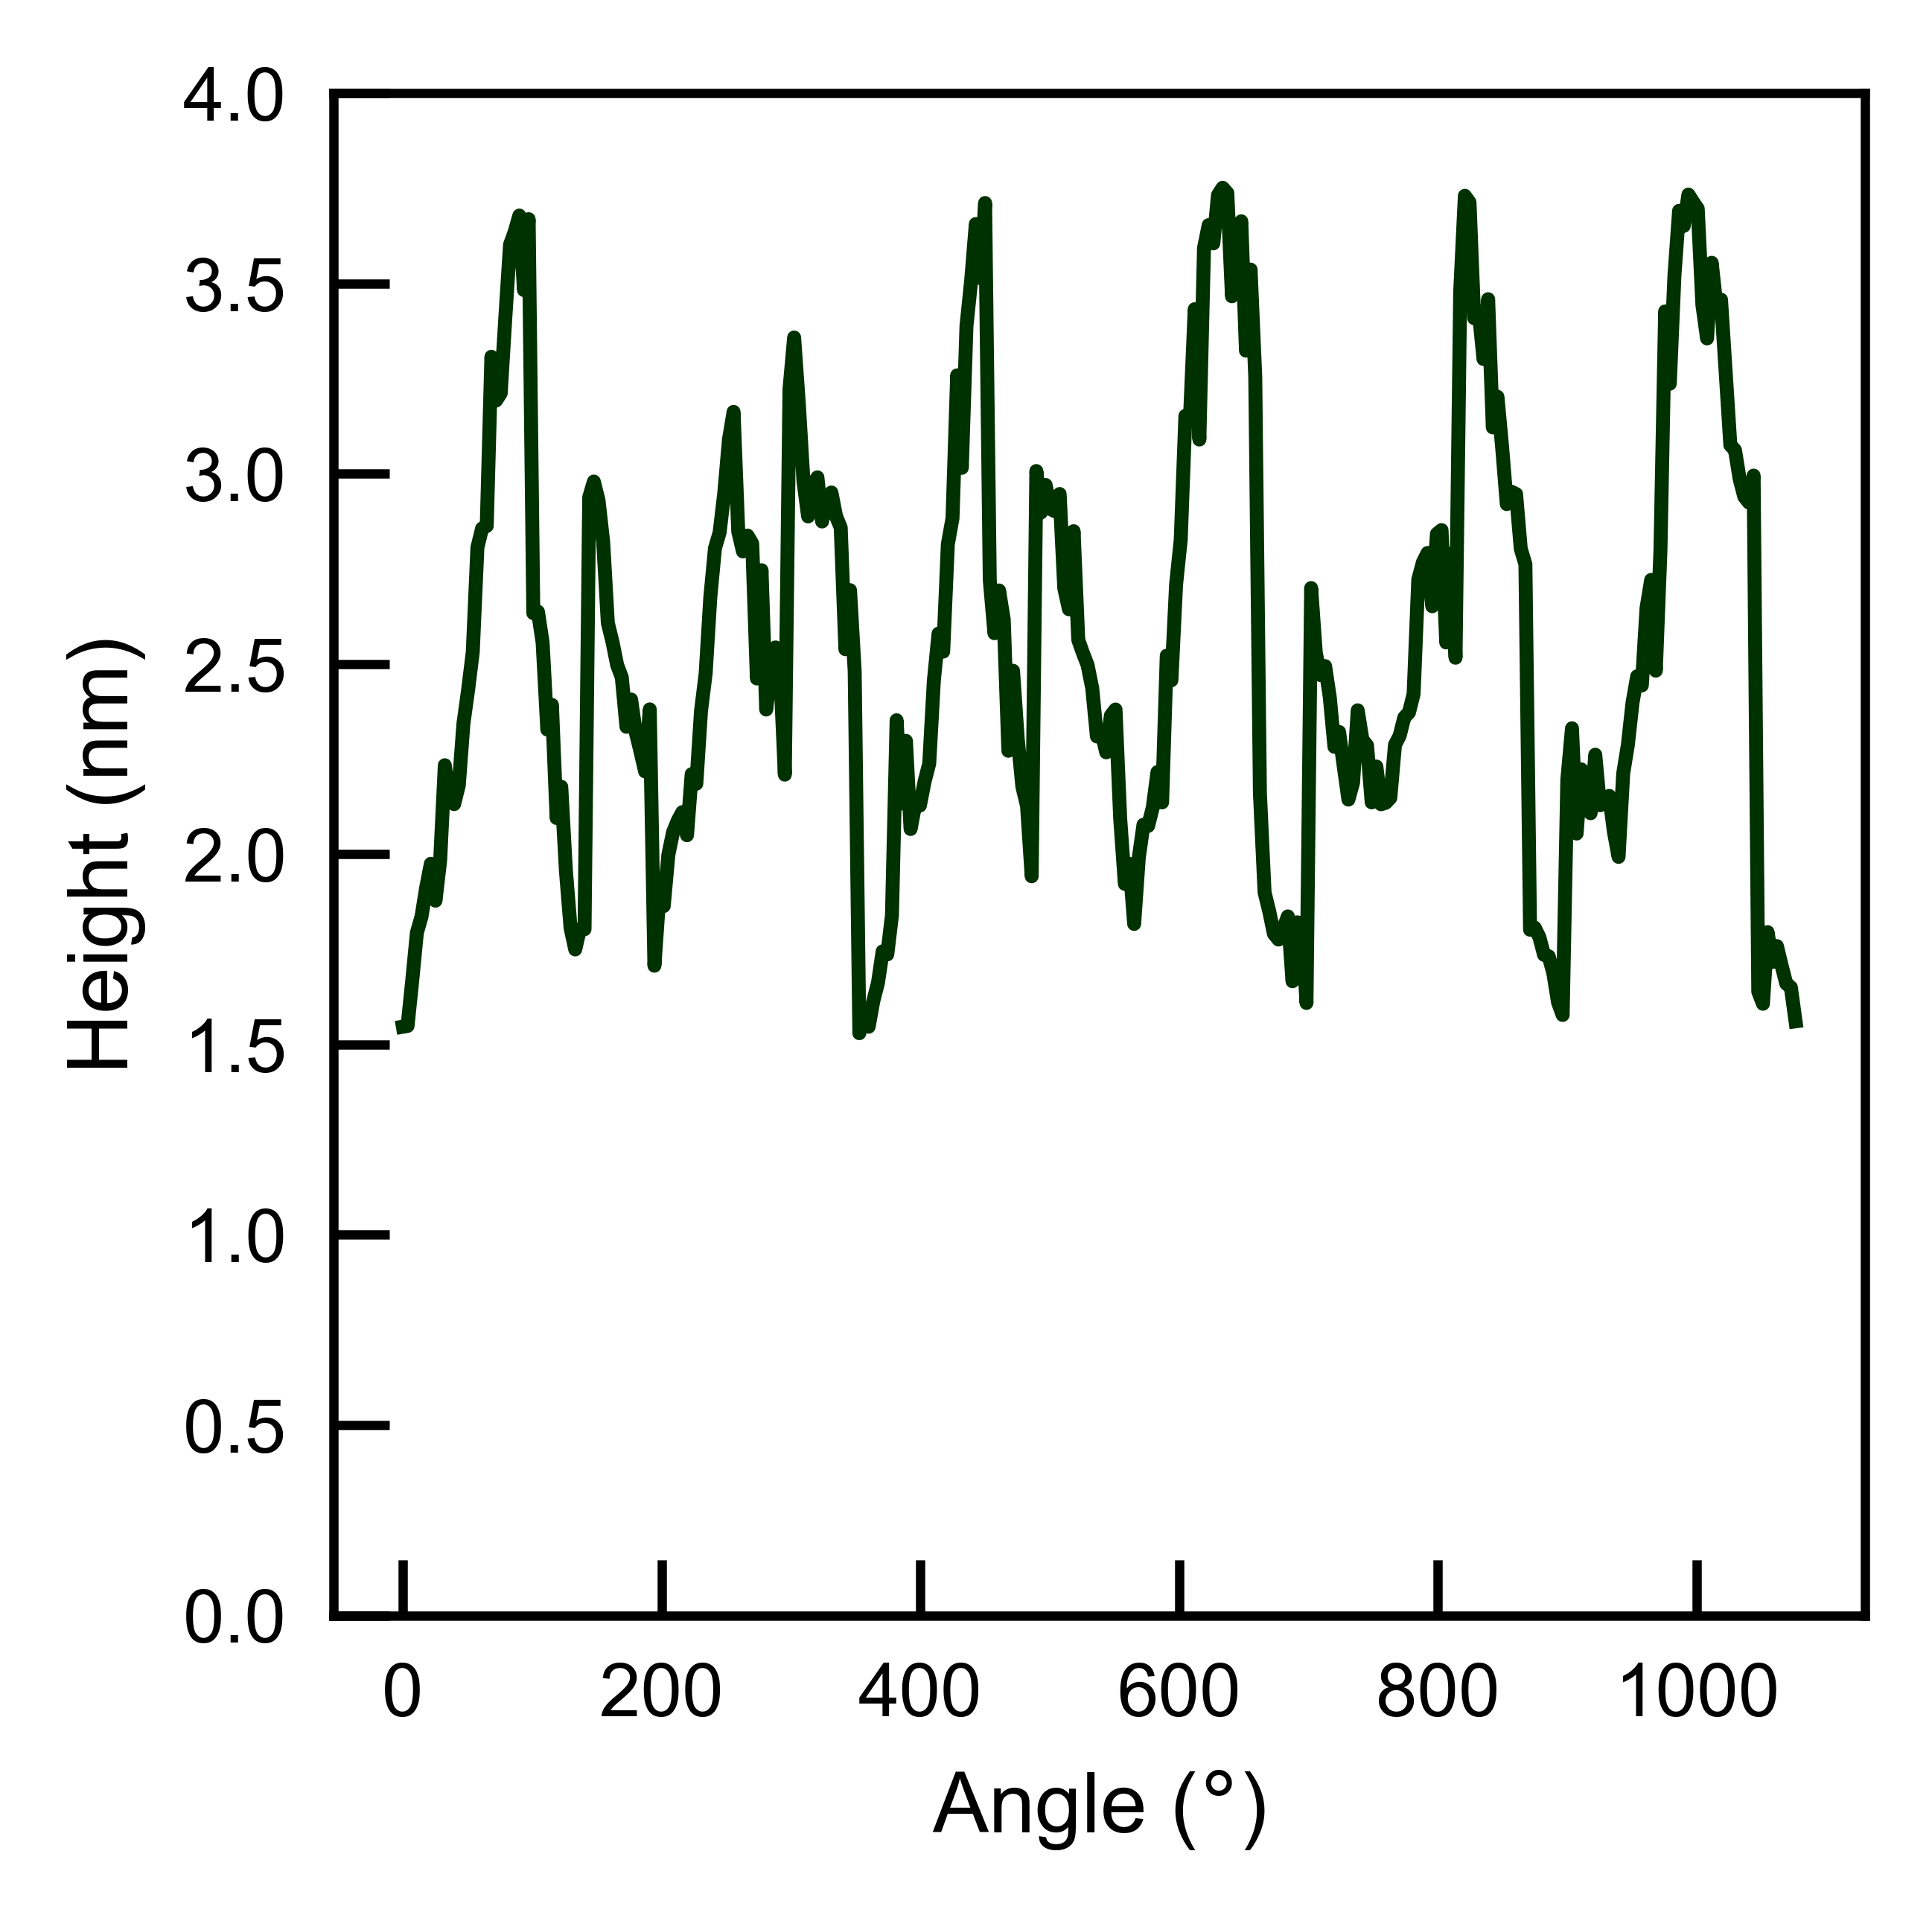

In [20]:
height_array = np.where(sequence, scans, scans_laminated)
fig, ax = plt.subplots(1, 1,)
ax.plot(angles, height_array)
ax.set_ylim(0, 4)
ax.set_xlabel('Angle ($\\degree$)')
ax.set_ylabel('Height (nm)')
# plt.savefig(f'./ugree_plot.svg')

plt.show()

# ウェーブレット変換

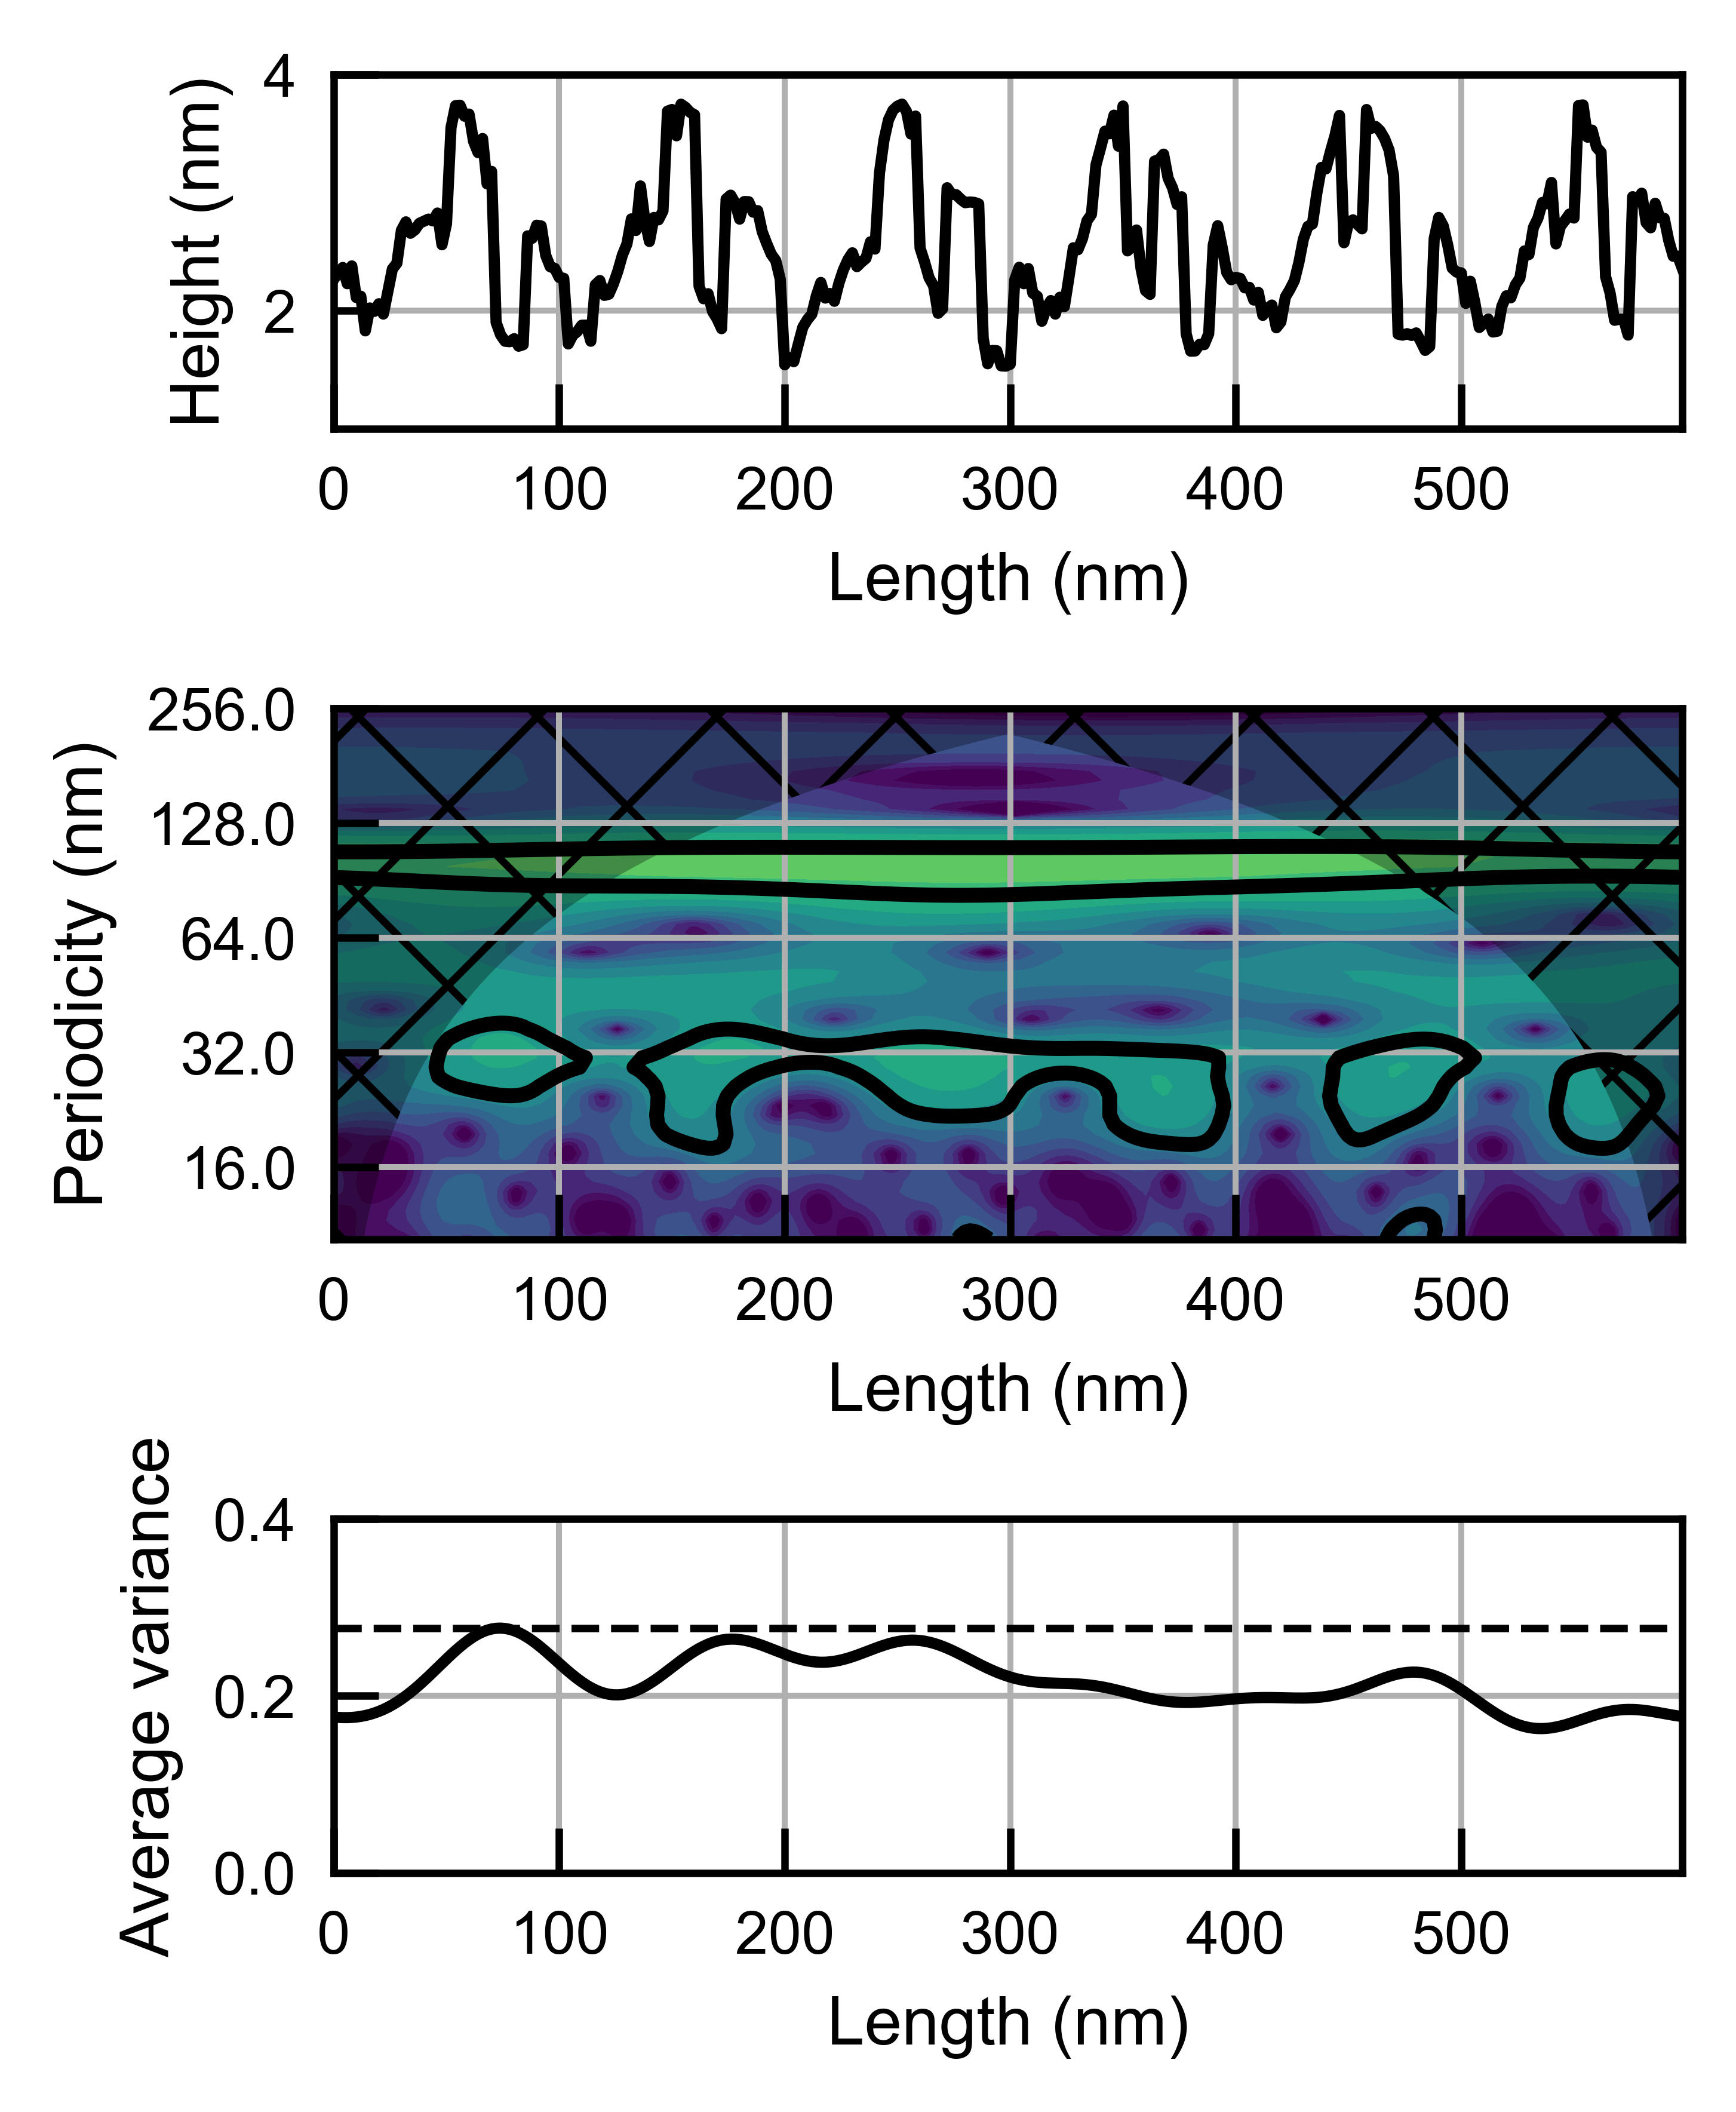

In [20]:
try:
    # dt = 1/1.8 # 1.8 nmごとにデータが取得されているとする(100 nmで180度回転)
    dt = 2
    height = height_array
    horizon = np.arange(0, len(height_array) * dt, dt)

    slevel = 0.95                        # Significance level

    std = height.std()                      # Standard deviation
    std2 = std ** 2                      # Variance
    dat = (height - height.mean()) / std       # Calculating anomaly and normalizing
    dat = np.where((-3 < dat) & (dat < 3), dat, 0) # 極端な値を除去
    
    N = dat.size                            # Number of measurements

    dj = 1 / 12 # 1 /  12                     # Twelve sub-octaves per octaves
    s0 = 5 * dt  # 2 * dt                    # Starting scale, here 6 months
    J = 7 / dj  # 7 / dj                     # Seven powers of two with dj sub-octaves
    #  alpha = 0.0                       # Lag-1 autocorrelation for white noise
    try:
        alpha, _, _ = wavelet.ar1(dat)   # Lag-1 autocorrelation for red noise
    except Warning:
        # When the dataset is too short, or there is a strong trend, ar1 raises a
        # warning. In this case, we assume a white noise background spectrum.
        alpha = 1.0

    mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

    # The following routines perform the wavelet transform and siginificance
    # analysis for the chosen data set.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,
                                                          mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother)

    # Normalized wavelet and Fourier power spectra
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    avg1, avg2 = (32, 128)                  # Range of periods to average

    # Significance test. Where ratio power/sig95 > 1, power is significant.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=slevel,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Power rectification as of Liu et al. (2007). TODO: confirm if significance
    # test ratio should be calculated first.
    # power /= scales[:, None]

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)

    # Scale average between avg1 and avg2 periods and significance level
    sel = find((period >= avg1) & (period < avg2))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power / scale_avg
    scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)

    fig = plt.figure(figsize=(3.3, 4))
    # gs = GridSpec(3, 2, width_ratios=[3, 1], height_ratios=[2, 3, 2])
    gs = GridSpec(3, 1, height_ratios=[2, 3, 2])

    ax_nino3 = fig.add_subplot(gs[0, 0])
    ax_wave = fig.add_subplot(gs[1, 0], sharex=ax_nino3)
    # ax_gl_spec = fig.add_subplot(gs[1, 1], sharey=ax_wave)
    ax_scl_avg = fig.add_subplot(gs[2, 0], sharex=ax_nino3)
    # for a in [ax_nino3, ax_wave, ax_gl_spec, ax_scl_avg]:
    for a in [ax_nino3, ax_wave, ax_scl_avg]:
        a.grid(True)

    ax_nino3.plot(horizon, height, 'k', linewidth=1.5)
    ax_nino3.set_ylim(1,4)
    ax_nino3.set_ylabel('Height (nm)')
    ax_nino3.set_xlabel('Length (nm)')

    # Contour plot wavelet power spectrum
    # ax_wave.set_title('Wavelet Scalogram')
    # levels = np.exp2(np.arange(-5, 6))
    levels = np.exp2(np.arange(-5, 10))
    ax_wave.contourf(horizon, np.log2(period), np.log2(power), np.log2(levels),
                     extend='both', cmap=plt.cm.viridis)
    extent = horizon.min(), horizon.max(), 0, max(period)

    ax_wave.contour(horizon, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                    extent=extent) # 95% significance contour

    ax_wave.fill(np.concatenate([horizon, horizon[-1:] + dt, horizon[-1:] + dt,
                                 horizon[:1] - dt, horizon[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
    # ax_wave.set_title(f'b) {label} Wavelet Power Spectrum ({mother.name})')
    ax_wave.set_ylabel('Periodicity (nm)')
    ax_wave.set_xlabel('Length (nm)')
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
    ax_wave.set_yticks(np.log2(Yticks))
    ax_wave.set_yticklabels(Yticks)
    # ax_wave.set_ylim(np.log2([period.min(), period.max()]))
    ax_wave.set_ylim(np.log2([period.min(), 256]))
    # print(period.max())

    # The global wavelet and Fourier power spectra
    # ax_gl_spec.plot(glbl_signif, np.log2(period), 'k--')
    # ax_gl_spec.plot(std2 * fft_theor, np.log2(period), '--', color='#cccccc')
    # ax_gl_spec.plot(std2 * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc')
    # ax_gl_spec.plot(std2 * glbl_power, np.log2(period), 'k') # todo なんでここでstd2をかけているのか？
    # 
    # ax_gl_spec.set_title('Global Wavelet Spectrum')
    # ax_gl_spec.set_xlim([0, glbl_power.max() + std2])
    # ax_gl_spec.set_ylim(np.log2([period.min(), period.max()]))
    # ax_gl_spec.set_yticks(np.log2(Yticks))
    # ax_gl_spec.set_yticklabels(Yticks)
    # ax_gl_spec.set_xlabel('Power')
    # plt.setp(ax_gl_spec.get_yticklabels(), visible=False)

    # Scale-averaged power spectrum
    ax_scl_avg.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax_scl_avg.plot(horizon, scale_avg, 'k-', linewidth=1.5)
    # ax_scl_avg.set_title(f'{avg1}-{avg2} nm scale-average power')
    ax_scl_avg.set_xlabel('Length (nm)')
    ax_scl_avg.set_ylabel('Average variance')

    ax_scl_avg.set_xlim([horizon.min(), horizon.max()])
    ax_scl_avg.set_yticks(np.arange(0, 0.6, 0.2))

    plt.tight_layout()
    # plt.close()
    image_dir = Path(f'./Figure/Distorted_wavelet/')
    if not image_dir.exists():
        image_dir.mkdir(parents=True)
    # plt.savefig(image_dir / 'distorted_wavelet.png', dpi=900)
    plt.show()
except RuntimeWarning:
    print('Divided by zero')